# Proposed Abundance-Threshold-Finding Heuristic

**Amanda Birmingham, CCBB, UCSD**

## Introduction

Currently the fitness-scoring pipeline for dual CRISPR screens requires a manual step wherein a researcher examines a histogram of the count distribution for each sample+timepoint and from this graphical representation, selects a threshold below which abundance constructs will not be included (in order to remove noisy data that can swamp the detection of real fitness effects).  

The manual nature of this step prevents full automation of the analysis pipeline, and the fact that different researchers may make different abundance threshold choices introduces a point of variation in the analysis.  I therefore seek to develop a deterministic heuristic to repeatably and automatically identify an acceptable abundance threshold value in arbitrary dual CRISPR screen data.

## Previous Work

In the dual CRISPR manuscript, this description of the abundance-threshold issue is provided:

"To avoid fitting Eq. 3 to spurious data, we use only data points above a certain threshold (Supplementary Fig. 4). The threshold depends mainly on the size of the sample (number of cells) collected at a given time in relation to the size of the viral library and on the depth of sequencing. We note that the left-most peak in the histograms of (Supplementary Fig. 4) contains severely undersampled constructs with zero counts. Their x-coordinate corresponds to a pseudo-count of one introduced only for visualization purposes. It is arbitrary and therefore should not be used for fitting the model. Likewise, finite but very low counts are considered missing data. We set a threshold for every time point (red lines in Supplementary Fig. S4)."

According to the above-quoted manuscript text, the threshold depends on:
* the number of cells in the sample
* the size of the viral library
* the depth of sequencing

The existing code that preps the count data and creates the abundance histograms from which threshold choices are inferred is shown below:

In making the plot, the only variable (beyond the per-construct counts themselves) that is used is "abundance"--that is, the sum of all the construct counts for a given sample. Undoubtedly it is fair to say that this overall abundance is influenced by all three of the factors listed above, although the nature of their influence a black box to us at the point we get the abundance.

## Development of the Heuristic

### Starting Data

I note that, for the purposes of threshold selection, every sample has its frequency calculated against its own personal abundance.  Within a given sample, the abundance is a constant, so dividing by it is really just shifting the log2 values by a constant amount: logb(m/n) = logb(m) – logb(n) so log2(t(gooddata)/abundance) = log2(t(gooddata)) - log2(abundance).  Since the thresholds are picked for each sample individually, rather than being picked with info taken from across multiple samples, I believe that we should be able to safely leave the abundance constant for a sample out of the threshold picking process for that sample and instead look straight at the log2(raw count) values.

### Training Sets

*1) Good data*

Let us examine a distribution of count values (on a log2 scale) for some real data that is high-quality and well-behaved (Hela.CV4R4R_d3_1_S7_L001_001), using a slimmed-down and slightly modified version of the above plotting algorithm:

In [339]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))
options(repr.plot.width=7, repr.plot.height=7)    
options(digits=10)

In [343]:
drawCountDists1<-function(countsDf, manualThresholds=NULL){
    countsDf[countsDf==0]<-1 #pseudocounts
    rge<-range(log2(countsDf))
    xPositions = seq(from = 0, to = ceiling(rge[2])+1, by = 1)
    xLabels = 2^(xPositions)

    for (i in 1:(length(colnames(countsDf)))) {
        log2CurrCounts<-log2(countsDf[,i])
        log2CurrCountsHist<-hist(log2CurrCounts,
            breaks=seq(0-0.05,rge[2]+0.05,by=0.05),
            main=colnames(countsDf)[i],
            col="blue",
            border=FALSE, 
            xaxt = 'n', 
            xlab="")

        log2CurrCountsDensity<-density(log2CurrCounts, bw=0.2)
        scaleFactor = sum(log2CurrCountsHist$counts)*0.05
        lines(log2CurrCountsDensity$x, log2CurrCountsDensity$y*scaleFactor,col="black")
        axis(side = 1, at = xPositions, labels=xLabels, las=2)
        mtext("counts (pseudocount added to zeros only)", side=1, line=3)
        
        if (!is.null(manualThresholds)){
            if (length(manualThresholds)>=i){
                log2threshold = log2(manualThresholds[i])
                rug(log2threshold, col="black", lwd=3)  
            }
        }
    }
}

In [319]:
goodCounts = read.table("~/Desktop/vgooddata.csv", sep=",", header=TRUE)
head(goodCounts, 10)

,Hela.CV4R4R_d3_1_S7_L001_001_trimmed53_len_filtered
1,107
2,313
3,345
4,134
5,93
6,364
7,116
8,89
9,98
10,227


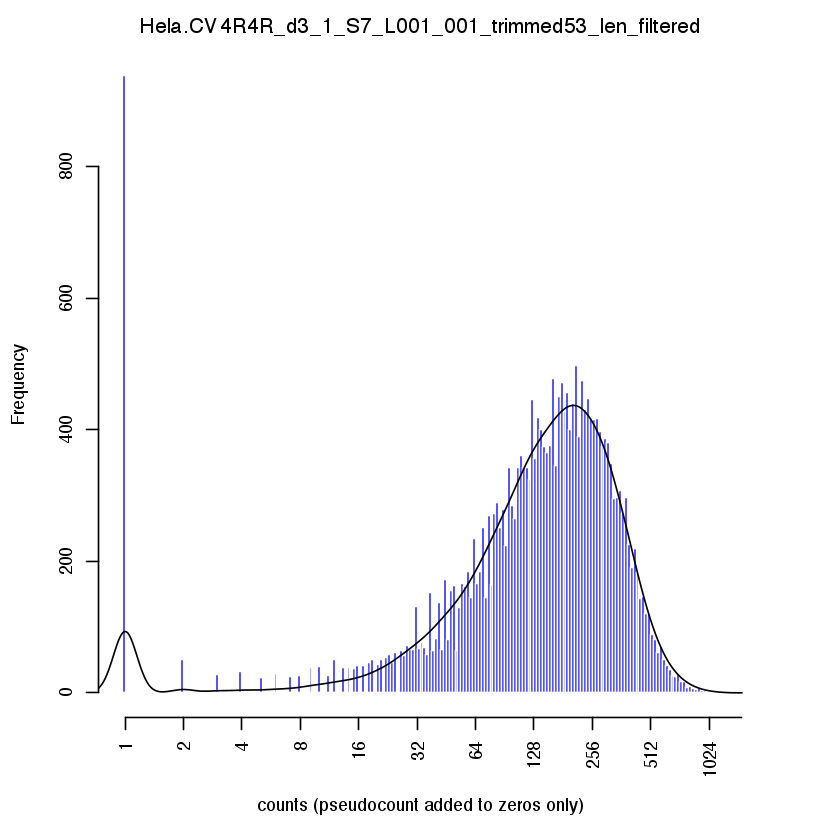

In [340]:
drawCountDists1(goodCounts)

In his methodII.pdf provided on 20160708, Roman showed his selected threshold for this dataset:

![](2016-12-27_6.08.12_PM.png)

I note that the y scales are different, apparently due to my dataset having more zeroes; I have not verified this hypothesis, but I think this is probably due to the fact that I'm visualizing the unmodified counts files while Roman's code removes all the counts for constructs with two non-targeting probes before visualization.  Also, I do not have the actual numerical value of the threshold; this is perhaps less problematic than one might think given (as noted above) that I want to work from the raw counts (visualized on a log scale) rather than the log2 of the abundance-normalized counts (visualized on a linear scale).  I therefore aim to approximate the position of the abundance threshold line on the distribution rather than to replicate the abundance threshold number, given the difference in units.  I manually estimate that the threshold on my graph which falls at approximately the same position as the threshold on Roman's graph is 12:

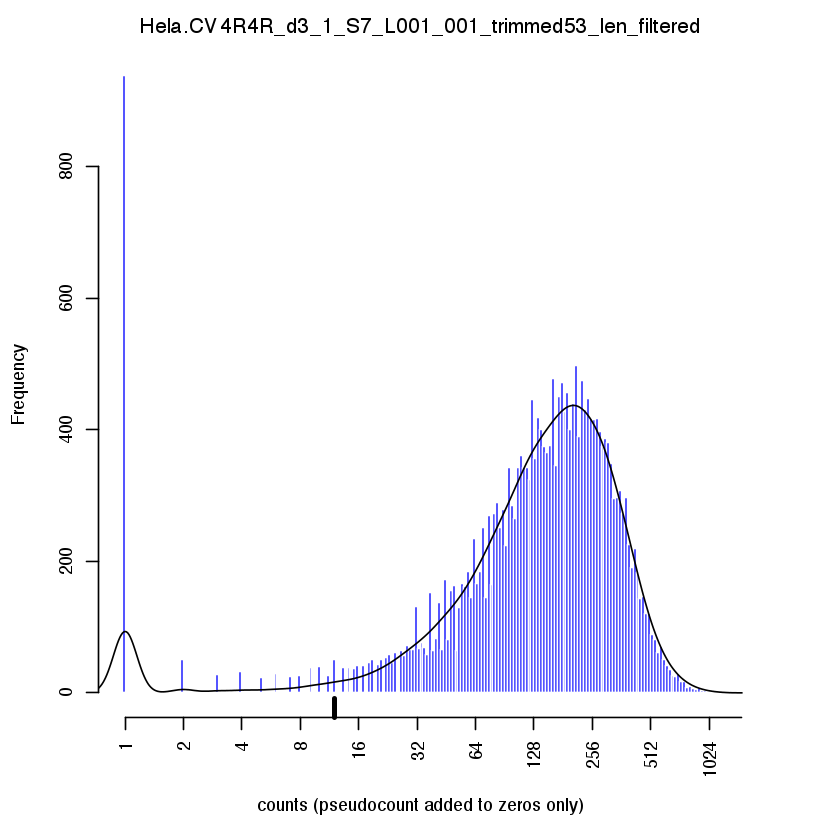

In [358]:
goodCountsManualThresholds = c(12)
drawCountDists1(goodCounts, goodCountsManualThresholds)

*2) Poor data*

The U20S Cas9Trex2 data had very low and somewhat malformed count distributions across all 8 sample+timepoints, as shown below:

In [323]:
poorCounts = read.table("~/Desktop/ab_y.csv", sep=",", header=TRUE)
head(poorCounts, 10)

,UCTAt1.2_S4_trimmed53_len_filtered_counts,UCTBt1.2_S5_trimmed53_len_filtered_counts,U2OS.CAS9TREX2A.t14_S1_trimmed53_len_filtered_counts,U2OS.CAS9TREX2B.t14_S2_trimmed53_len_filtered_counts,u2os_trex2a_t21_S4_trimmed53_len_filtered_counts,u2os_trex2b_t21_S5_trimmed53_len_filtered_counts,U2OS.CAS9TREX2A.t28_S5_trimmed53_len_filtered_counts,U2OS.CAS9TREX2B.t28_S6_trimmed53_len_filtered_counts
1,1239,1,41,49,268,1149,12,259
2,8,7,35,15,133,28,25,5
3,4,1,78,23,1732,319,96,39
4,591,1369,11,197,190,5106,14,657
5,1413,1,19,16,34,19,2,4
6,2544,11,203,103,2521,656,111,12
7,1,1,4,8,7,1,5,4
8,122,512,41,30,486,99,22,1
9,1,2,4,5,19,3,5,3
10,6,1,13,19,51,18,18,6


For these samples, I selected the thresholds and Roman approved them.  They were -18., -18., -16., -16., -18., -18., -16., -16 for the log2 of the abundance-normalized counts for these samples, which looked like this on the plots:

![](2017-01-04_ 9.51.55_AM.png)

![](2017-01-04_9.52.10_AM.png)

![](2017-01-04_9.52.47_AM.png)

![](2017-01-04_9.53.02_AM.png)

Below, I estimate the positions of these thresholds on the plots based on my preferred data and units:

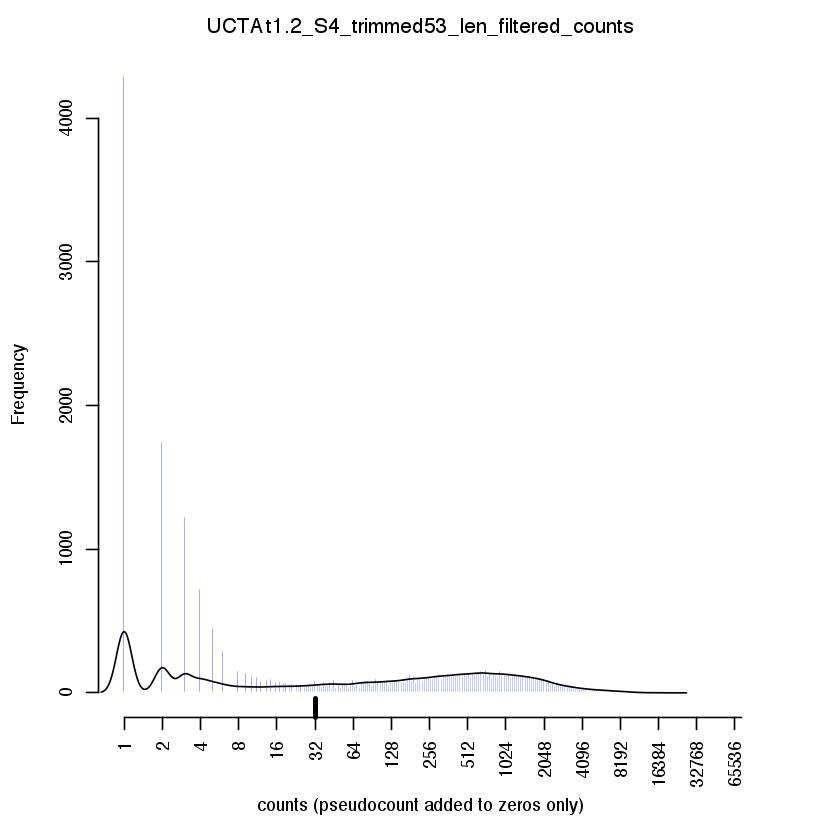

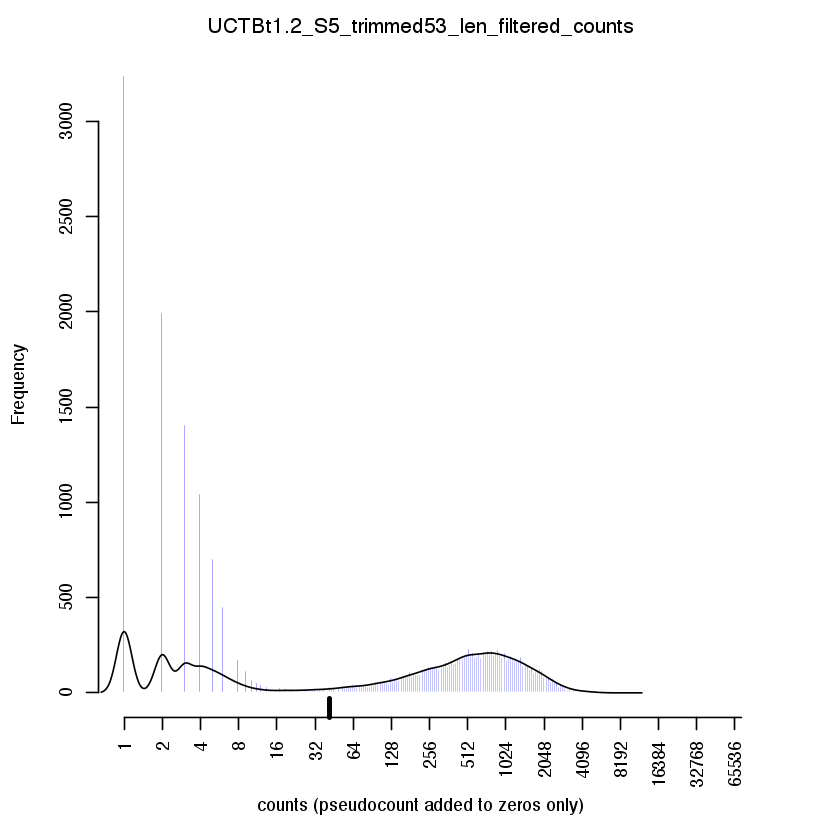

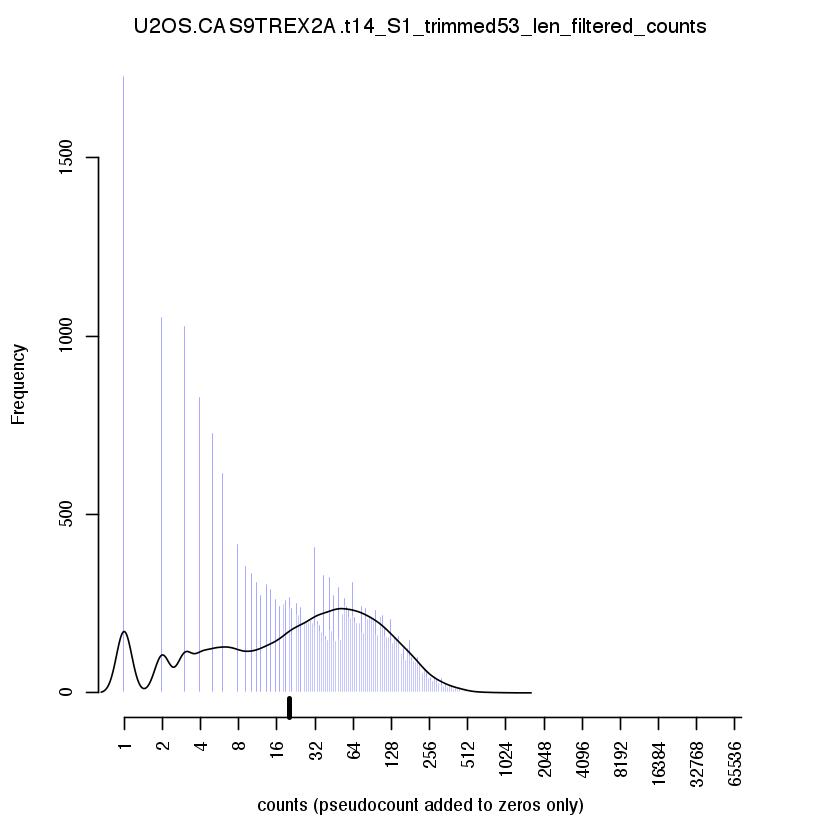

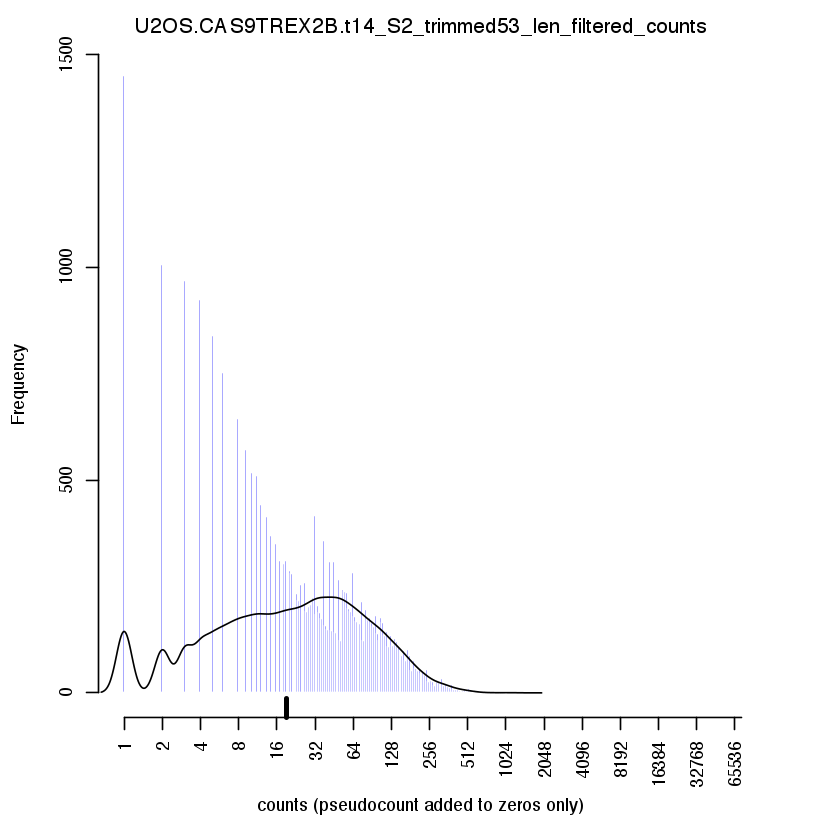

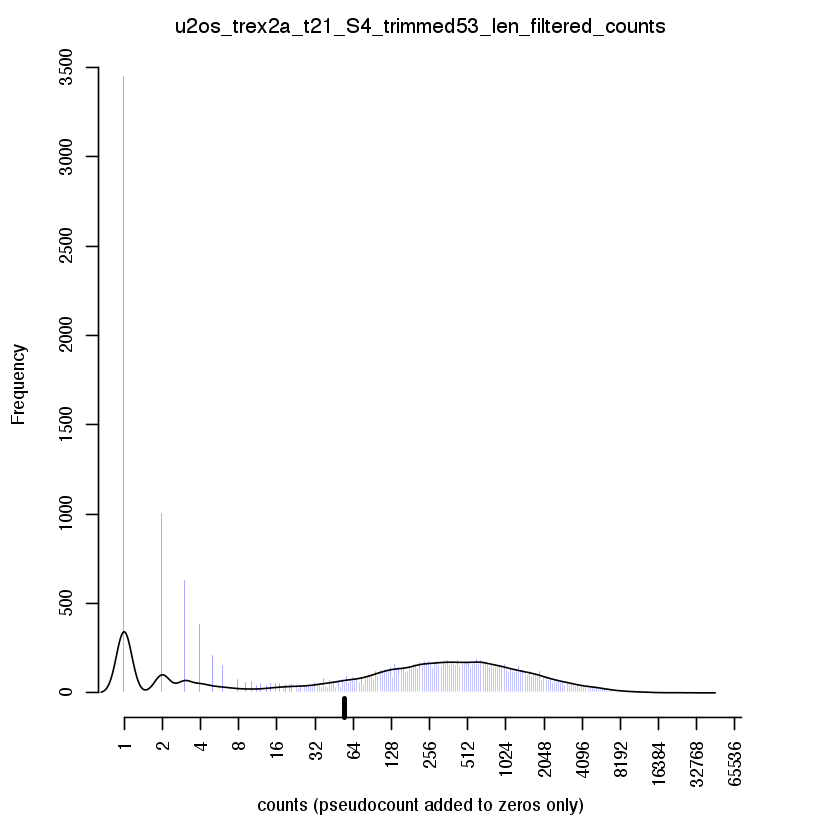

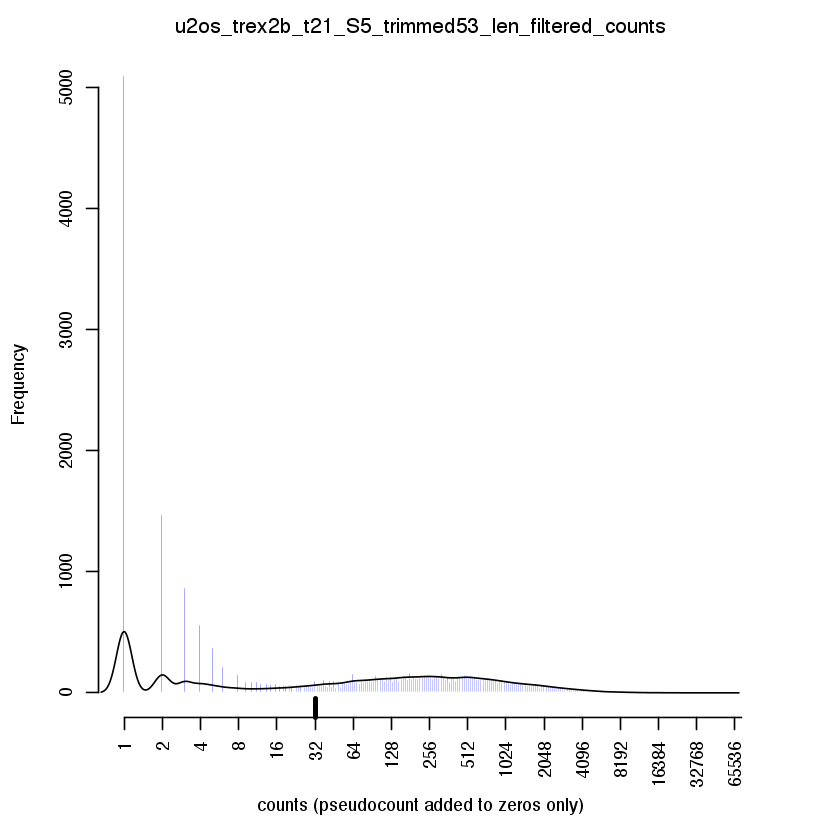

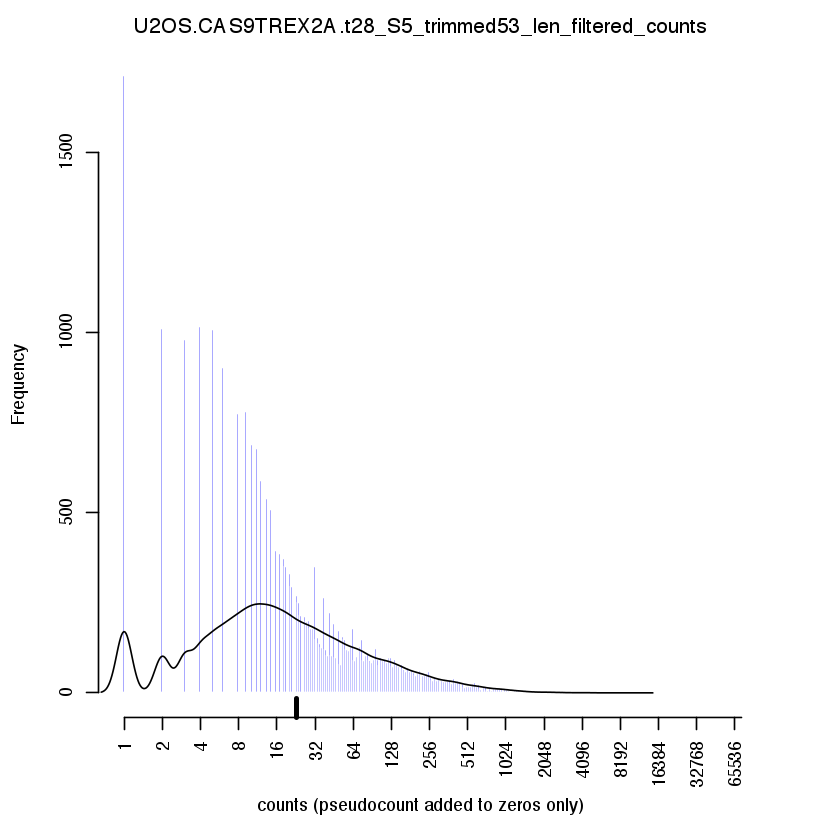

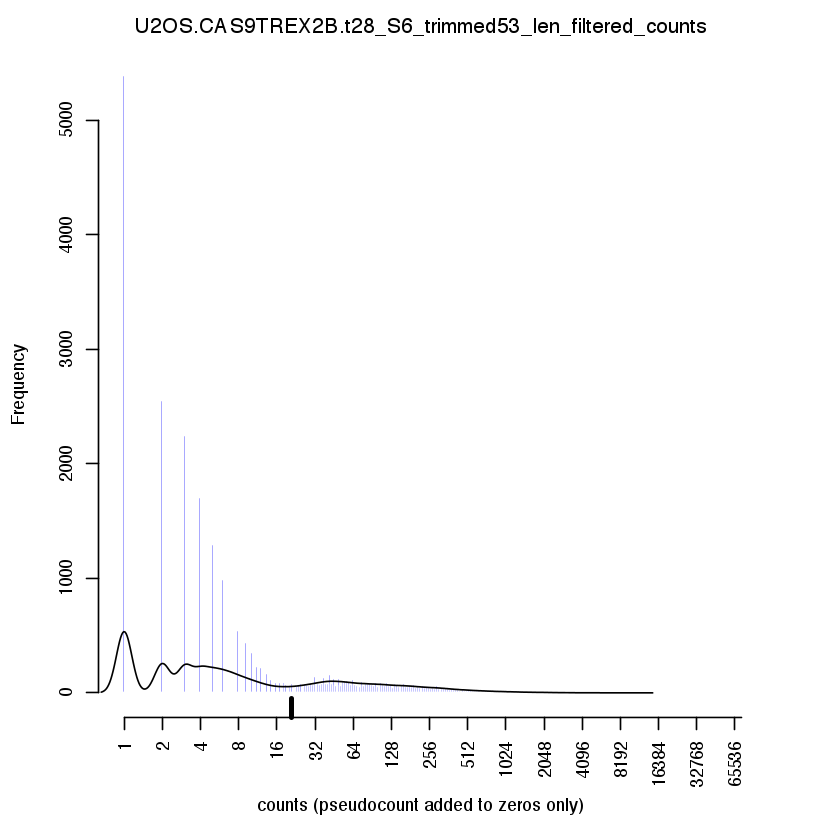

In [359]:
poorCountsManualThresholds = c(32, 42, 20, 19, 55, 32, 23, 21) 
drawCountDists1(poorCounts, poorCountsManualThresholds)

In discussions of how to select the thresholds shown above, I have been given two pieces of guidance: to look for where the histogram stops appearing quantized, and to select the apparent valley between the "noise" counts and the "main distribution".  I think I have to discount the first piece of advice as it is dependent the details of the visualization and scale.  The second, however, is a useful guide, so I start by trying to identify the interior (i.e., not at either end) minima in the count distributions.  The fitted density object includes discrete x and y values, so there's no need to even invoke calculus; I follow an approach described on Stack Overflow (https://stackoverflow.com/questions/6836409/finding-local-maxima-and-minima/6836583#6836583 ):

In [571]:
findDensityMinIndices<-function(densityObj){
    indicesOfMins = which(diff(sign(diff(densityObj$y)))==+2)+1
    return(indicesOfMins) 
}

plotDensityMins<-function(densityObj, indicesOfMins){
    minimums = densityObj$x[indicesOfMins]
    rug(minimums,col="red",lwd=2)   
}

findAndPlotDensityMins<-function(densityObj){
    indicesOfMins = findDensityMinIndices(densityObj)
    plotDensityMins(densityObj, indicesOfMins)
}

drawCountDists2<-function(countsDf, manualThresholds=NULL, extremaFunc=NULL){
    countsDf[countsDf==0]<-1 #pseudocounts
    rge<-range(log2(countsDf))
    xPositions = seq(from = 0, to = ceiling(rge[2])+1, by = 1)
    xLabels = 2^(xPositions)

    for (i in 1:(length(colnames(countsDf)))) {
        log2CurrCounts<-log2(countsDf[,i])
        log2CurrCountsHist<-hist(log2CurrCounts,
            breaks=seq(0-0.05,rge[2]+0.05,by=0.05),
            main=colnames(countsDf)[i],
            col="blue",
            border=FALSE, 
            xaxt = 'n', 
            xlab="")

        log2CurrCountsDensity<-density(log2CurrCounts)
        scaleFactor = sum(log2CurrCountsHist$counts)*0.05
        lines(log2CurrCountsDensity$x, log2CurrCountsDensity$y*scaleFactor,col="black")
        axis(side = 1, at = xPositions, labels=xLabels, las=2)
        mtext("counts (pseudocount added to zeros only)", side=1, line=3)
        
        if (!is.null(manualThresholds)){
            if (length(manualThresholds)>=i){
                log2threshold = log2(manualThresholds[i])
                rug(log2threshold, col="black", lwd=3)  
            }
        }
        
        if (!is.null(extremaFunc)){
            extremaFunc(log2CurrCountsDensity)
        }
    }
}

In [580]:
findMinIndices<-function(objWithXandY){
    indicesOfMins = which(diff(sign(diff(objWithXandY$y)))==+2)+1
    return(indicesOfMins) 
}


plotMins<-function(objWithXandY, indicesOfMins){
    minimums = objWithXandY$x[indicesOfMins]
    rug(minimums,col="red",lwd=2)   
}


findAndPlotMins<-function(objWithXandY){
    indicesOfMins = findMinIndices(objWithXandY)
    plotMins(objWithXandY, indicesOfMins)
}


drawCountsAndMins<-function(countsDf, manualThresholds=NULL, extremaFunc=NULL){
    countsDf[countsDf==0]<-1 #pseudocounts
    rge<-range(log2(countsDf))
    xPositions = seq(from = 0, to = ceiling(rge[2])+1, by = 1)
    xLabels = 2^(xPositions)

    for (i in 1:(length(colnames(countsDf)))) {
        log2CurrCounts<-log2(countsDf[,i])
        log2CurrCountsHist<-hist(log2CurrCounts,
            breaks=seq(0-0.05,rge[2]+0.05,by=0.05),
            main=colnames(countsDf)[i],
            col="blue",
            border=FALSE, 
            xaxt = 'n', 
            xlab="")        
        
        axis(side = 1, at = xPositions, labels=xLabels, las=2)
        mtext("counts (pseudocount added to zeros only)", side=1, line=3)
        
        # density curve
        log2CurrCountsDensity<-density(log2CurrCounts)
        scaleFactor = sum(log2CurrCountsHist$counts)*0.05
        lines(log2CurrCountsDensity$x, log2CurrCountsDensity$y*scaleFactor,col="grey")
        
        # smoothing spline curve of non-zero freqs only
        tempDf = data.frame(log2CurrCountsHist$mids, log2CurrCountsHist$count)
        colnames(tempDf) = c("x", "y")
        nonZeroLog2CurrCountsHist = tempDf[which(tempDf$y>0), ]
        ss = smooth.spline(nonZeroLog2CurrCountsHist$x, nonZeroLog2CurrCountsHist$y) #, spar=0.35)
        lines(ss)

        # rug plots of manual thresholds
        if (!is.null(manualThresholds)){
            if (length(manualThresholds)>=i){
                log2threshold = log2(manualThresholds[i])
                rug(log2threshold, col="black", lwd=3)  
            }
        }        
        
        # rug plots determined by external function
        if (!is.null(extremaFunc)){
            extremaFunc(ss)
        }
    }
}

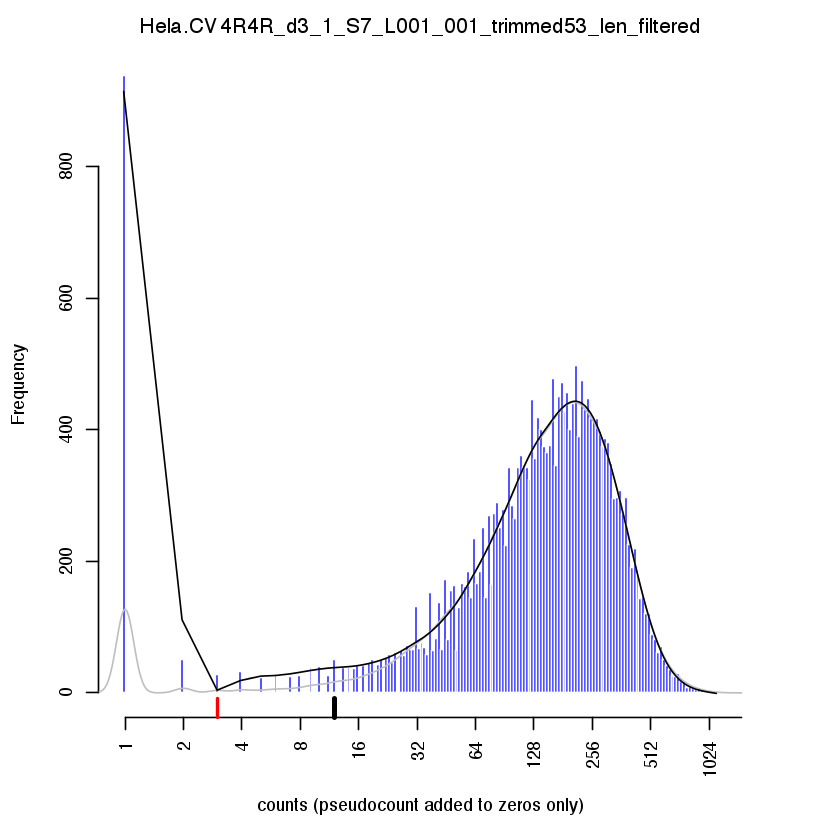

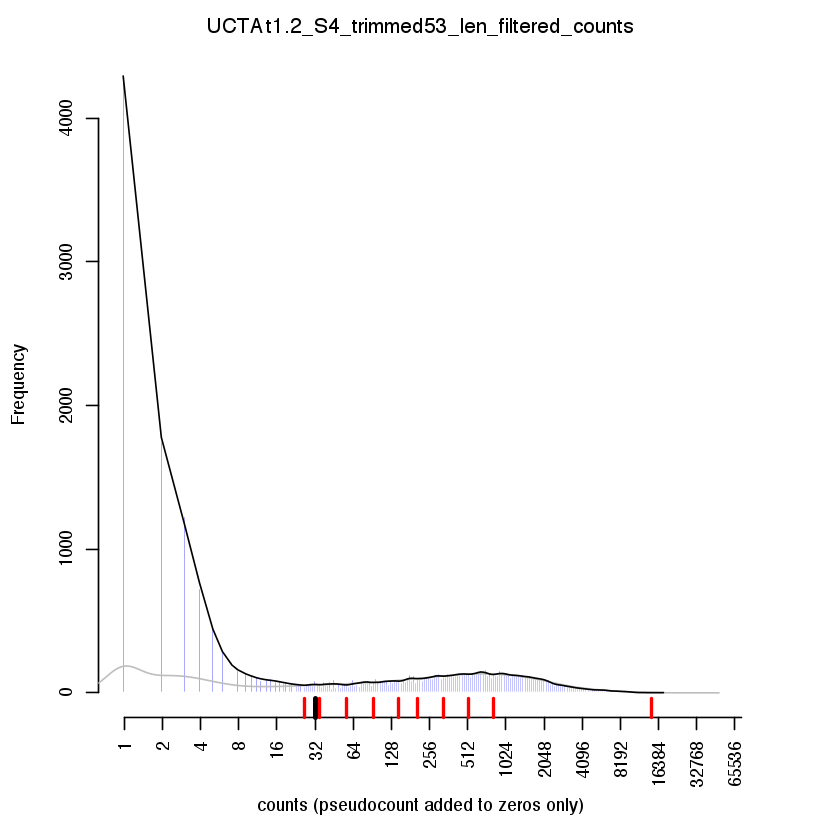

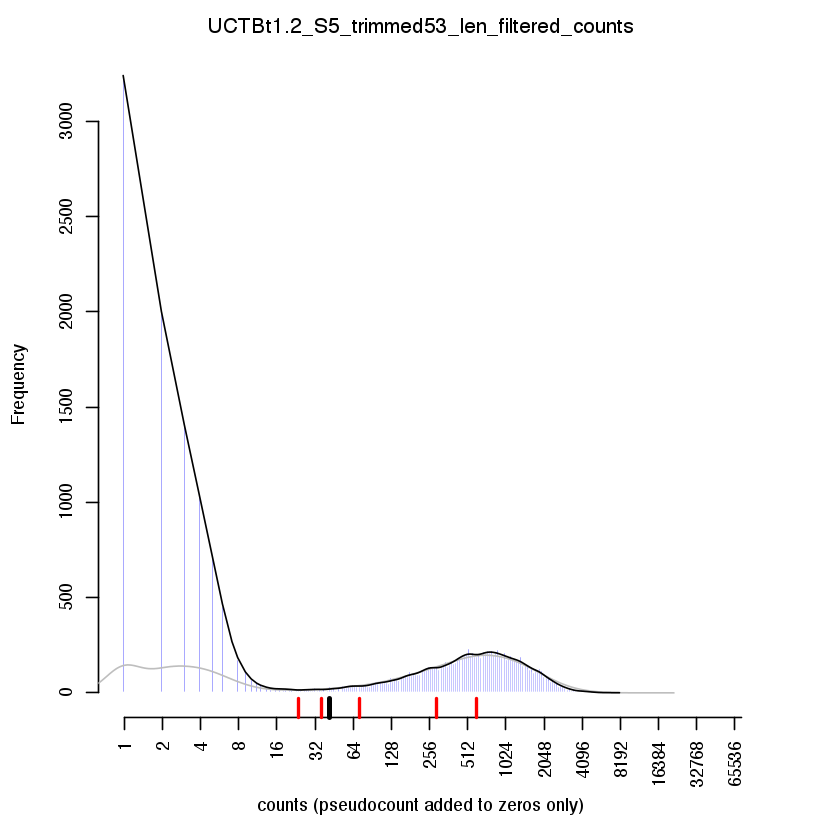

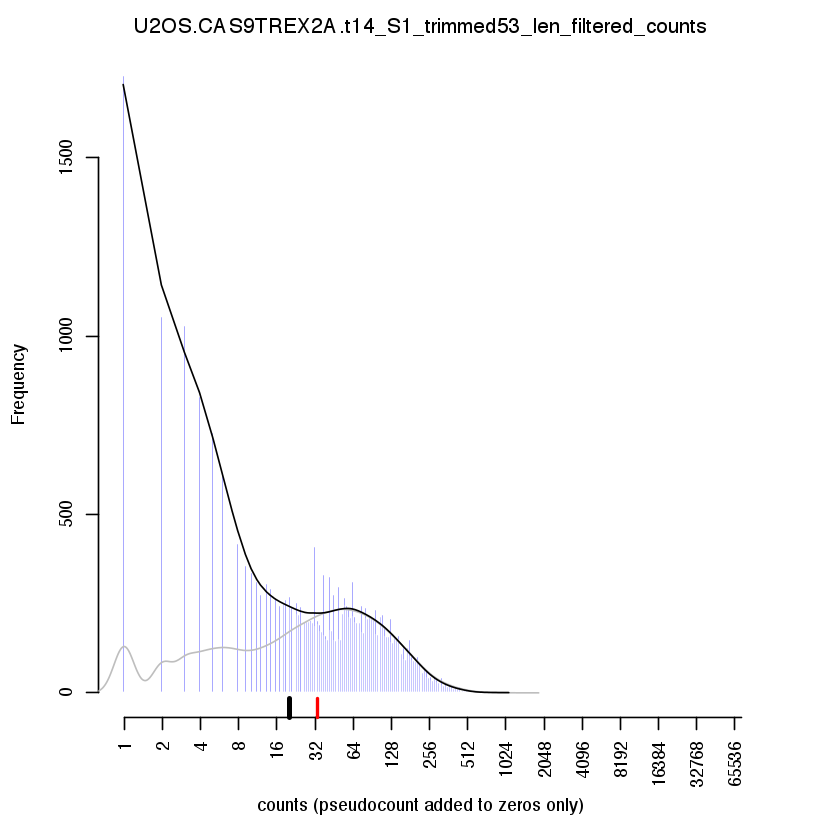

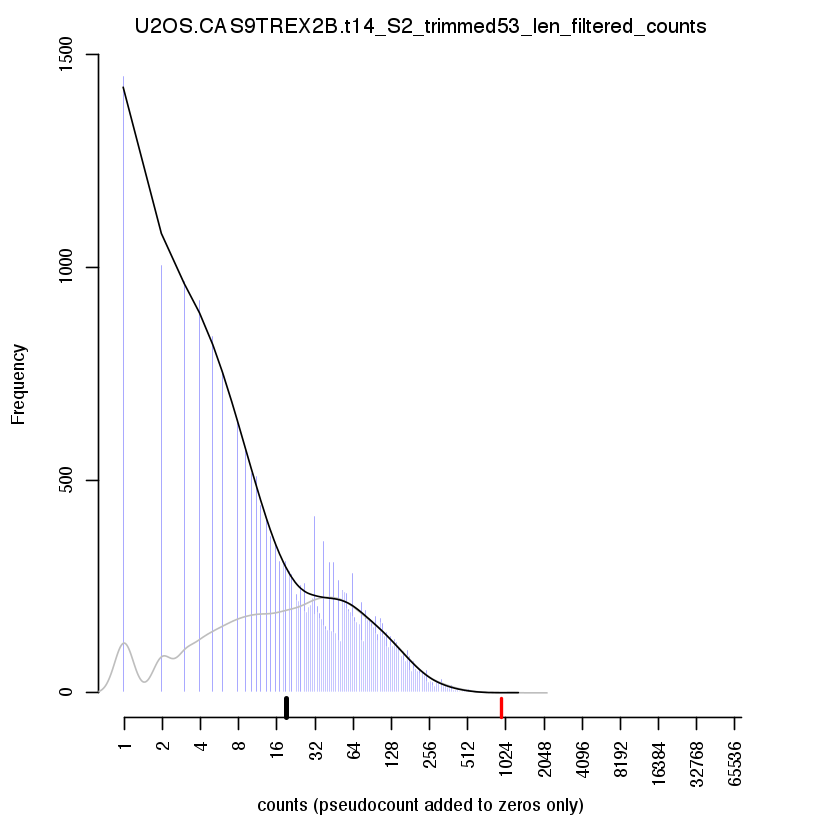

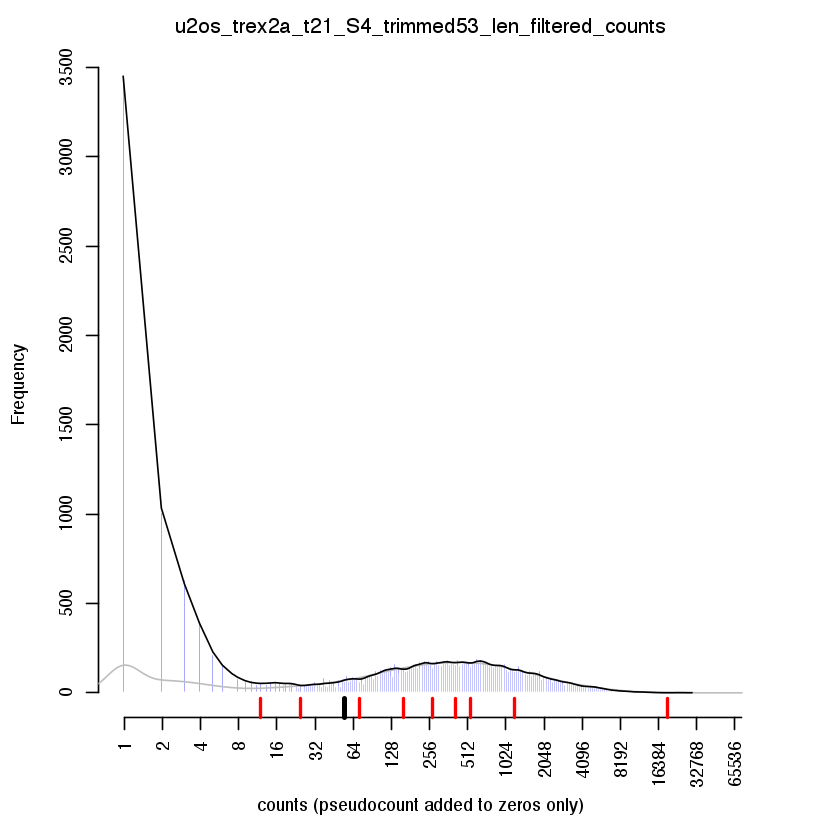

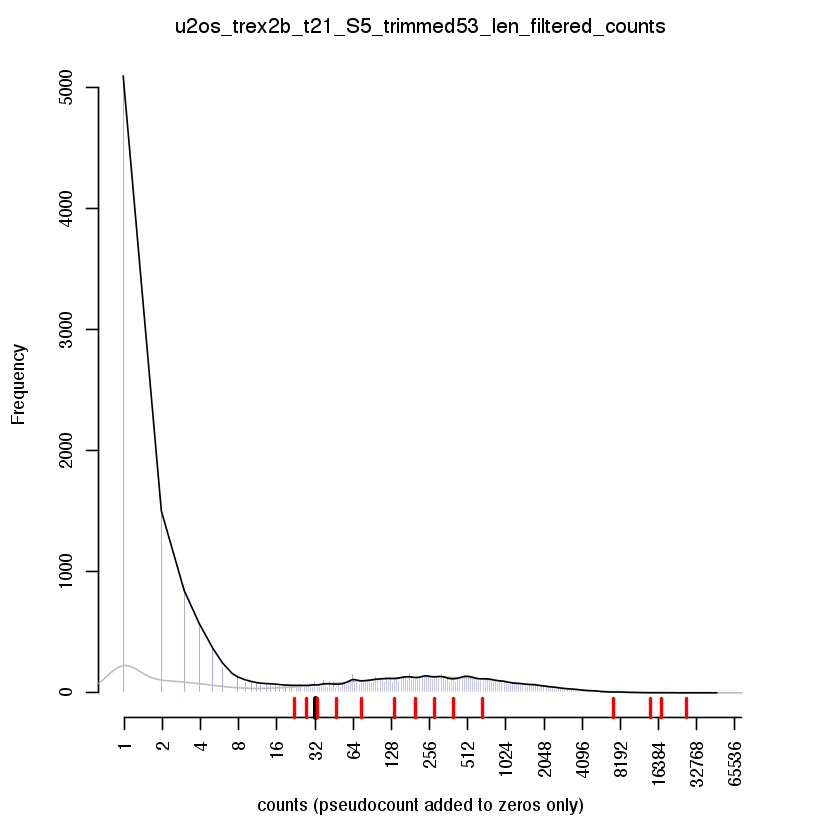

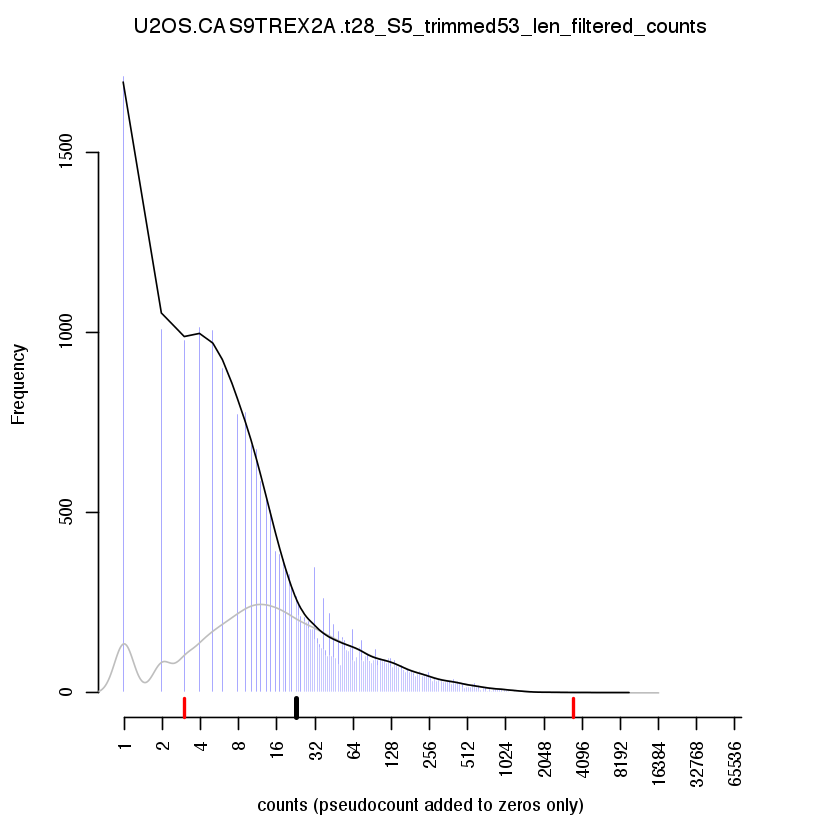

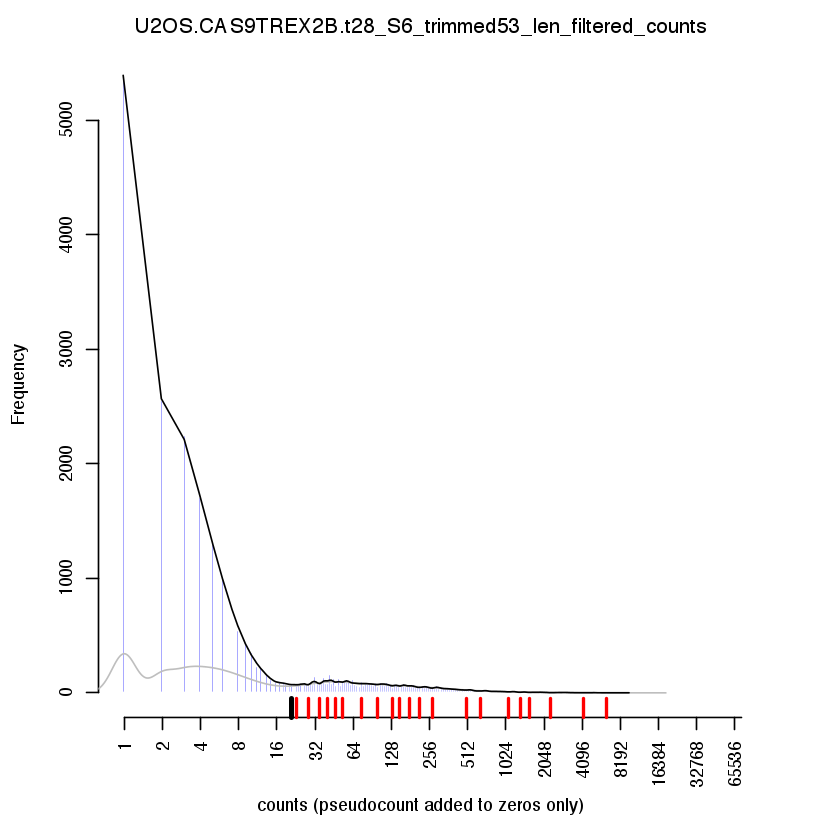

In [581]:
drawCountsAndMins(goodCounts, goodCountsManualThresholds, findAndPlotMins)
drawCountsAndMins(poorCounts, poorCountsManualThresholds, findAndPlotMins)

Hmm, well, that's something but not quite right.  Two issues:

1. There is more than one minimum, and the code will need to be able to pick which one on which to anchor.
2. While we may be choosing the general region of the graph based on the location of the valley between noise and main distribution, the thresholds are actually a bit to the right (i.e., toward higher counts) than the nadir of that valley.  

#### Issue 1: There is more than one minimum, and the code will need to be able to pick which one on which to anchor

How about if I say I want the right-most minimum?  Works well on the good data shown above.  How would it work on the poor data?

Warning message:
In rug(minimums, col = "red", lwd = 2): some values will be clippedWarning message:
In rug(minimums, col = "red", lwd = 2): some values will be clipped

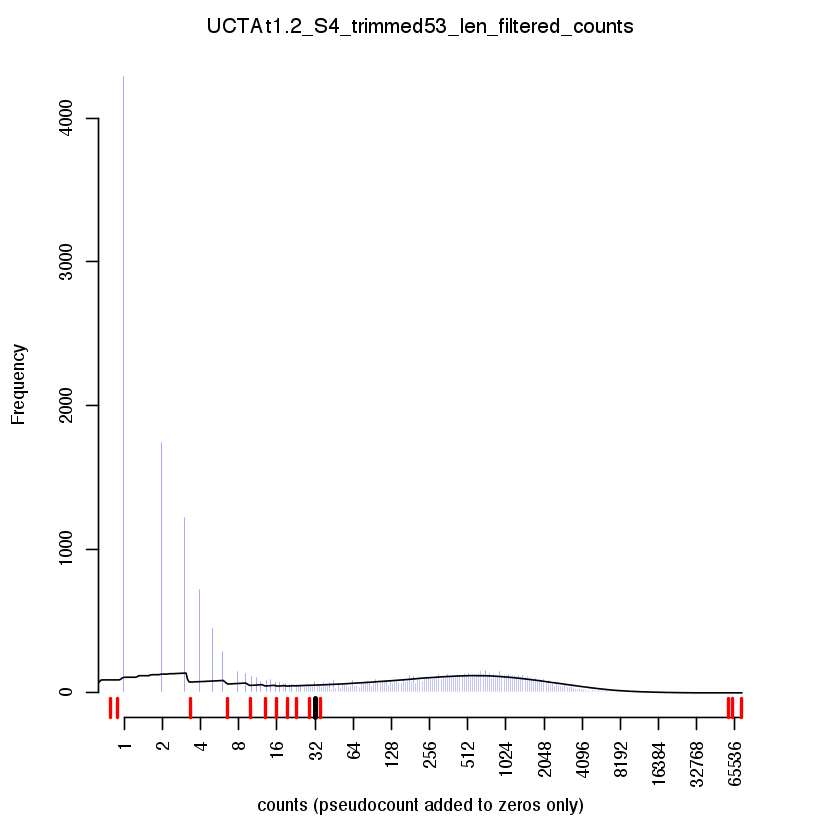

Warning message:
In rug(minimums, col = "red", lwd = 2): some values will be clipped

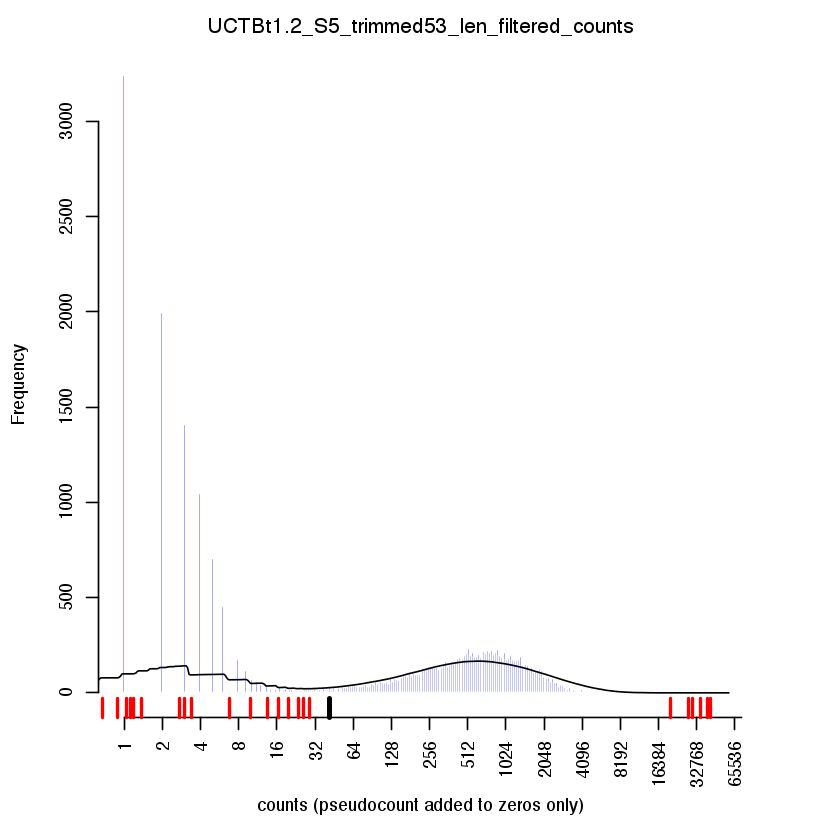

Warning message:
In rug(minimums, col = "red", lwd = 2): some values will be clipped

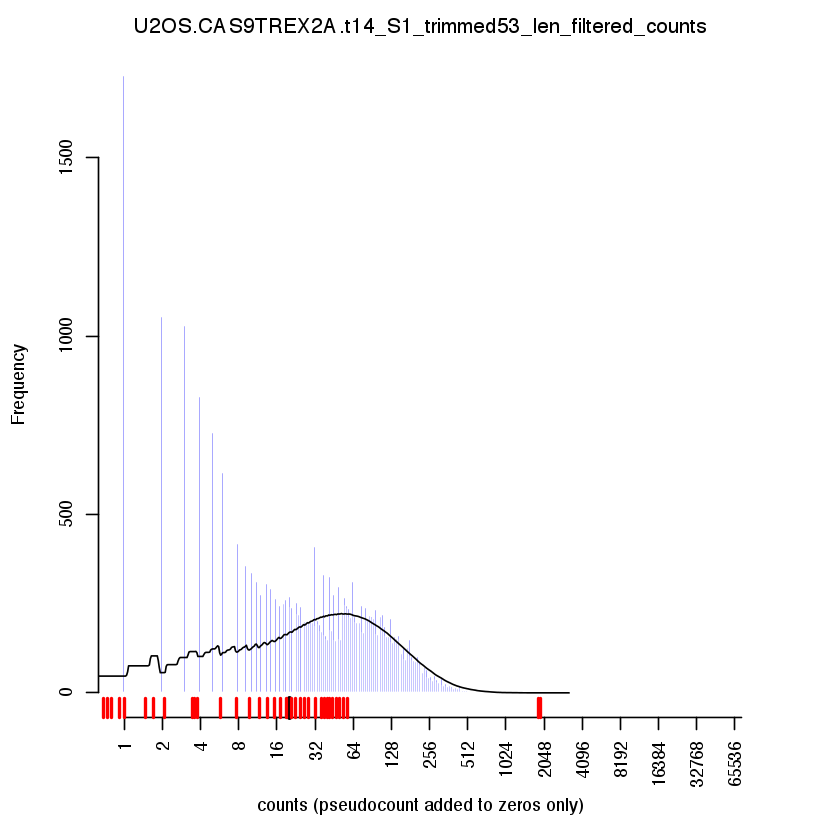

Warning message:
In rug(minimums, col = "red", lwd = 2): some values will be clipped

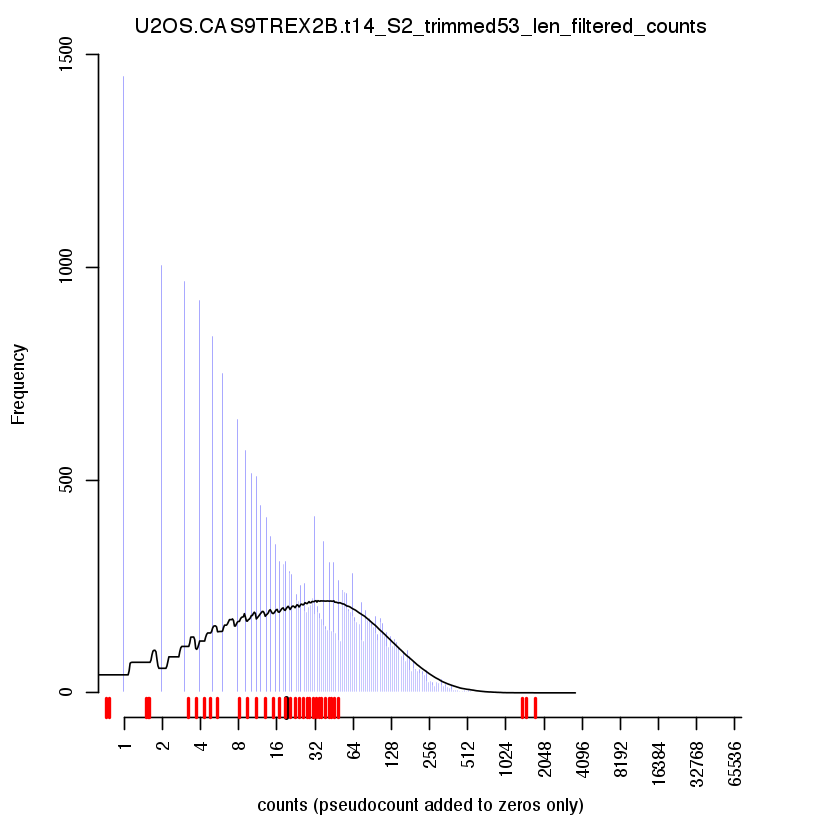

Warning message:
In rug(minimums, col = "red", lwd = 2): some values will be clipped

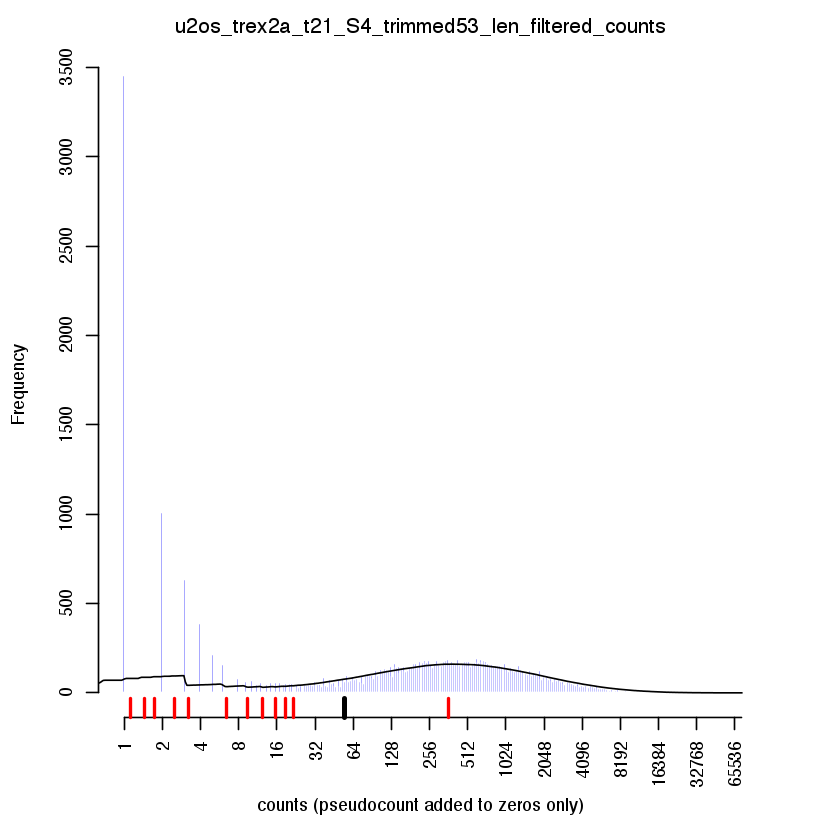

Warning message:
In rug(minimums, col = "red", lwd = 2): some values will be clipped

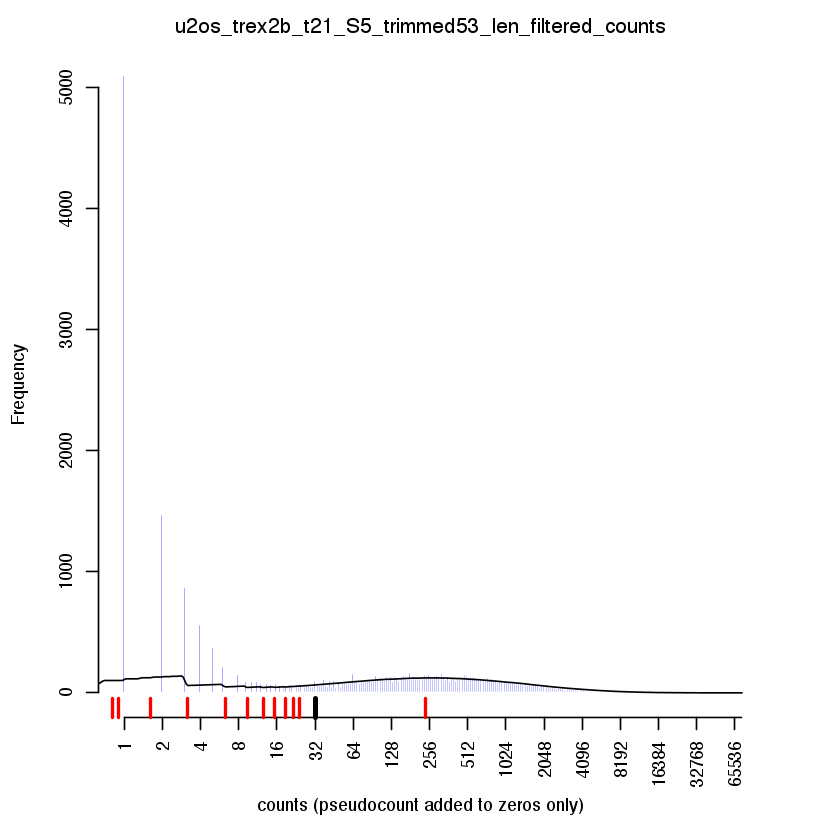

Warning message:
In rug(minimums, col = "red", lwd = 2): some values will be clipped

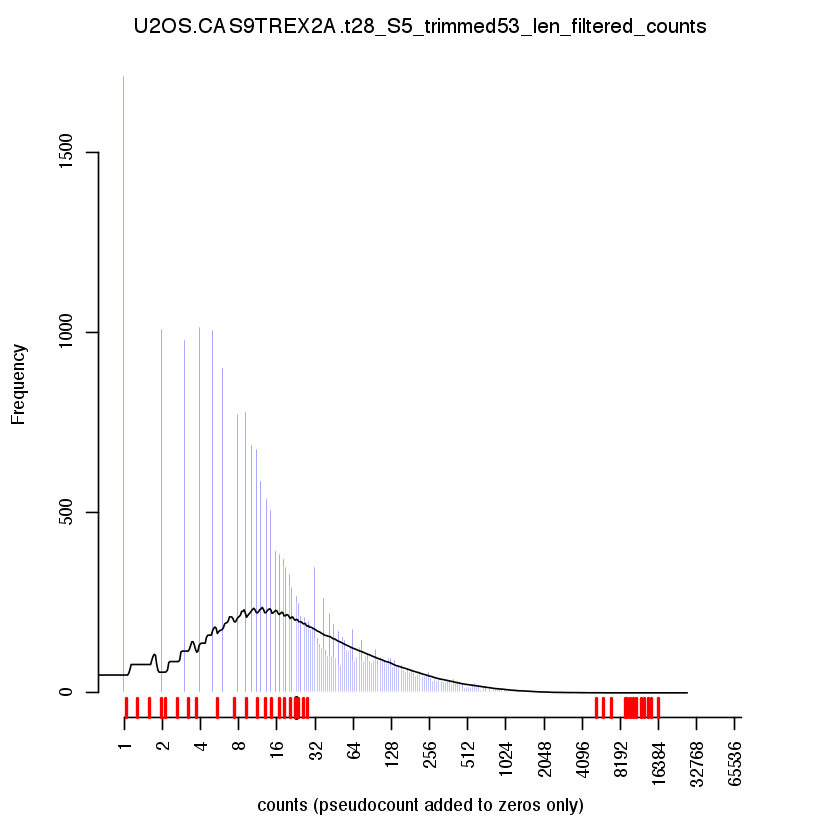

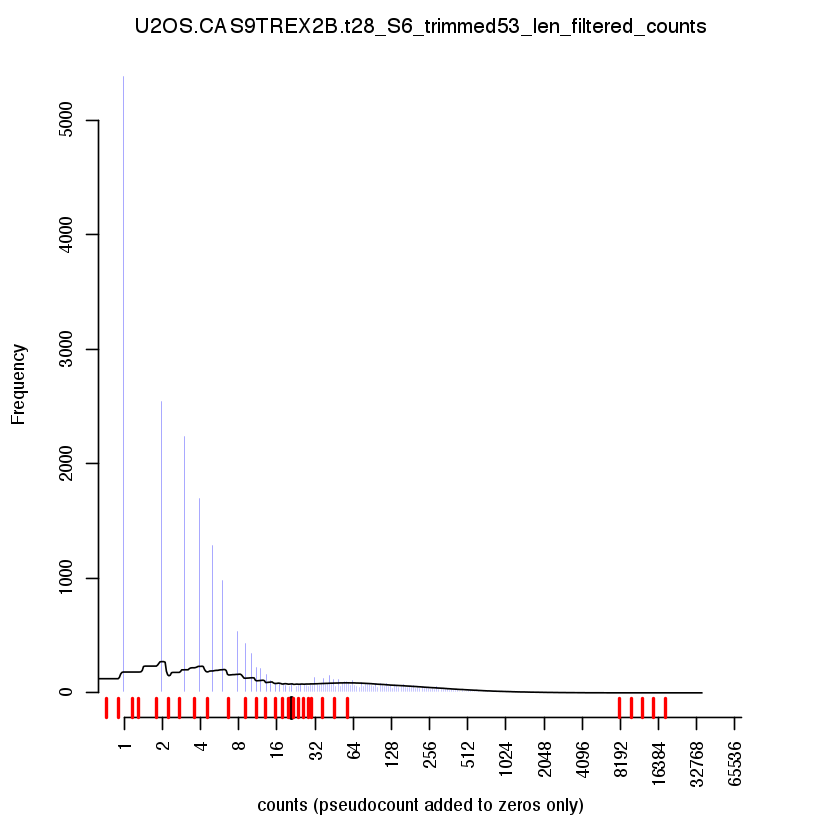

In [534]:
drawCountDists2(poorCounts, poorCountsManualThresholds, findAndPlotDensityMins)

Danger, Will Robinson! While the "rightmost minimum" heuristic is acceptable for UCTBt1.2_S5, 
U2OS.CAS9TREX2A.t14_S1, and U2OS.CAS9TREX2B.t28_S6, the others have problems.  These problems are caused by the fact that we're looking for *local* minima (which we have to do because often the global interior minimum is right next to the zero-counts spike); these results show that it isn't unheard of to have local minima within the main distribution or even to the right of it.  

Ok, so how do I, as a human, know that I don't care about those little local minima outside the "valley"?  I think the key here is "little": I'm interested in the local minimum that preceeds the biggest jump in counts because that seems to be the one adjacent to the main count distribution.  To find that "jump in counts", I need to also find the interior local *maxima*.  I then need to calculate the difference between the frequency at each local minimum and at the maximum immediately to the right of it.  Although above I characterized this as a "jump in counts" when looking across the distribution from left to right, I decide it will be easier to code this if I reverse it and look for a "drop in counts" when progressing across the distribution from right to left.  

In [483]:
findAndPlotDensityExtremaAndDiffs<-function(densityObj){

    getMins = TRUE
    indicesOfMins = findDensityExtremaIndices(densityObj, getMins)
    plotDensityExtrema(densityObj, indicesOfMins, getMins)        
    
    getMins = FALSE
    indicesOfMaxes = findDensityExtremaIndices(densityObj, getMins)
    plotDensityExtrema(densityObj, indicesOfMaxes, getMins)   
    
    log2CountsAtChosenMin = getLog2CountsAtMinWithBiggestDiff(densityObj, 
        indicesOfMins, indicesOfMaxes)
    if (!is.null(log2CountsAtChosenMin)) {
        plotExplicitThresholds(c(log2CountsAtChosenMin), areLog2=TRUE, color="orange")        
    } else {
        print("No minimum chosen")
    }
}
     
    
getLog2CountsAtMinWithBiggestDiff<-function(densityObj, indicesOfMins, indicesOfMaxes){
    minsByDescLog2Counts = getlog2CountsAndFreqsAtExtrema(densityObj, indicesOfMins, TRUE)
    maxesByDescLog2Counts = getlog2CountsAndFreqsAtExtrema(densityObj, indicesOfMaxes, FALSE)
    currIndexOfMin = 1
    currIndexOfMax = 1
    if (minsByDescLog2Counts[1, "log2CountsAtExtrema"] > maxesByDescLog2Counts[1, "log2CountsAtExtrema"]){
        print("rightmost extremum is a minimum")
        currIndexOfMin = 2
    }    

    maxDiffInFreqs = 0
    log2CountsAtMinWithBiggestDiff = NULL

    while ((currIndexOfMin <= nrow(minsByDescLog2Counts)) & 
           (currIndexOfMax <= nrow(maxesByDescLog2Counts))) {

        currMaxFreq = maxesByDescLog2Counts[currIndexOfMax, "freqsAtExtrema"]
        currMinFreq = minsByDescLog2Counts[currIndexOfMin, "freqsAtExtrema"]

        currFreqDiff = currMaxFreq - currMinFreq
        if (currFreqDiff > maxDiffInFreqs){
            maxDiffInFreqs = currFreqDiff
            log2CountsAtMinWithBiggestDiff = minsByDescLog2Counts[currIndexOfMin, "log2CountsAtExtrema"]
        }
        currIndexOfMin = currIndexOfMin + 1
        currIndexOfMax = currIndexOfMax + 1
    }    
    
    return(log2CountsAtMinWithBiggestDiff)
}
       

getlog2CountsAndFreqsAtExtrema<-function(densityObj, indicesOfExtrema, getMins=TRUE){
    log2CountsAtExtrema = densityObj$x[indicesOfExtrema]
    densityFunc = approxfun(densityObj)
    freqsAtExtrema = densityFunc(log2CountsAtExtrema)
    result = data.frame(log2CountsAtExtrema, freqsAtExtrema)
    result = result[with(result, order(-log2CountsAtExtrema)), ]   
    return(result)    
}        
        

plotExplicitThresholds<-function(thresholdsList, thresholdIndex=1, areLog2=FALSE, color="black"){
    if (!is.null(thresholdsList)){
        if (length(thresholdsList)>=i){
            currThreshold = thresholdsList[thresholdIndex]
            log2threshold = if(areLog2) currThreshold else log2(currThreshold)
            rug(log2threshold, col=color, lwd=3)  
        }
    }          
}
        
        
drawCountDists3<-function(countsDf, manualThresholds=NULL, extremaFunc=NULL){
    countsDf[countsDf==0]<-1 #pseudocounts
    rge<-range(log2(countsDf))
    xPositions = seq(from = 0, to = ceiling(rge[2])+1, by = 1)
    xLabels = 2^(xPositions)

    for (i in 1:(length(colnames(countsDf)))) {
        log2CurrCounts<-log2(countsDf[,i])
        log2CurrCountsHist<-hist(log2CurrCounts,
            breaks=seq(0-0.05,rge[2]+0.05,by=0.05),
            main=colnames(countsDf)[i],
            col="blue",
            border=FALSE, 
            xaxt = 'n', 
            xlab="")

        log2CurrCountsDensity<-density(log2CurrCounts)
        scaleFactor = sum(log2CurrCountsHist$counts)*0.05
        lines(log2CurrCountsDensity$x, log2CurrCountsDensity$y*scaleFactor,col="black")
        axis(side = 1, at = xPositions, labels=xLabels, las=2)
        mtext("counts (pseudocount added to zeros only)", side=1, line=3)
        
        plotExplicitThresholds(manualThresholds, i)
        
        if (!is.null(extremaFunc)){
            extremaFunc(log2CurrCountsDensity)
        }
    }
}

The minimum selected as the putative abundance threshold for each sample will be shown in orange.  Here goes:

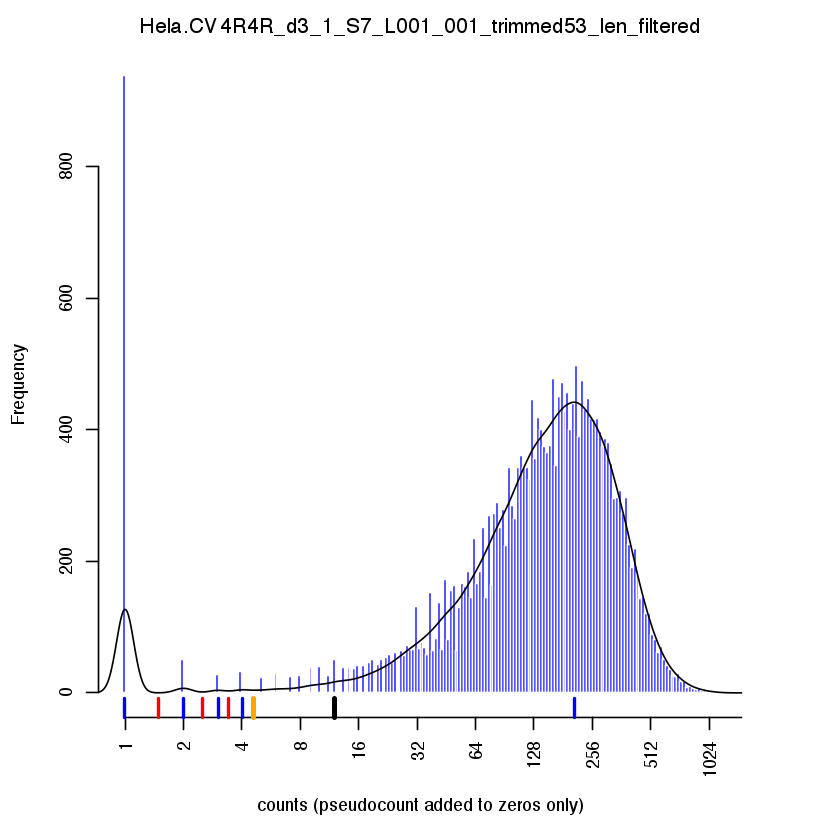

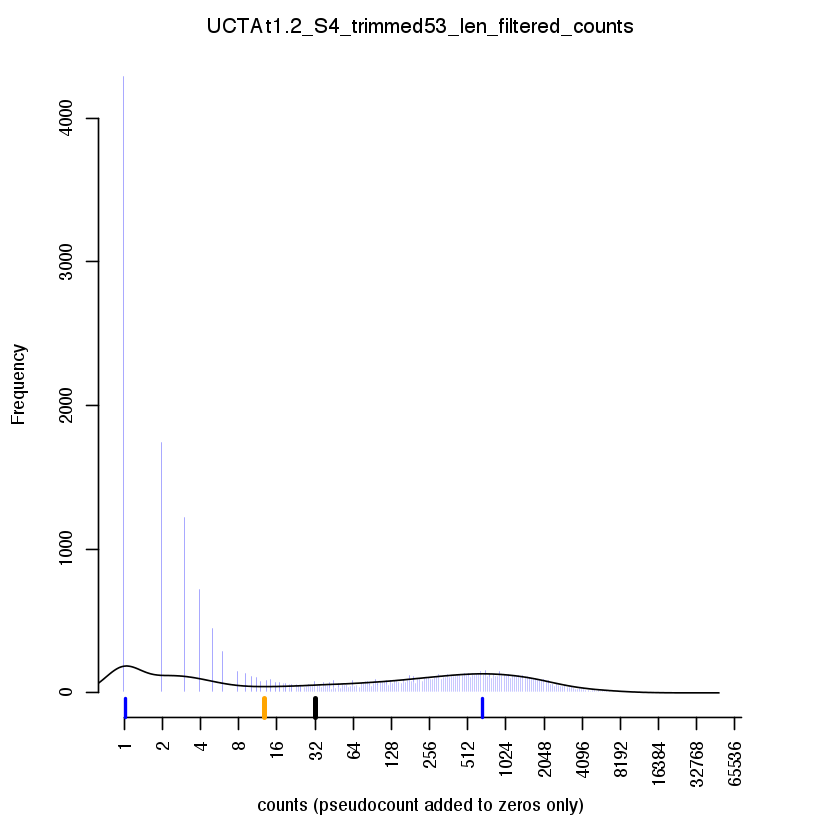

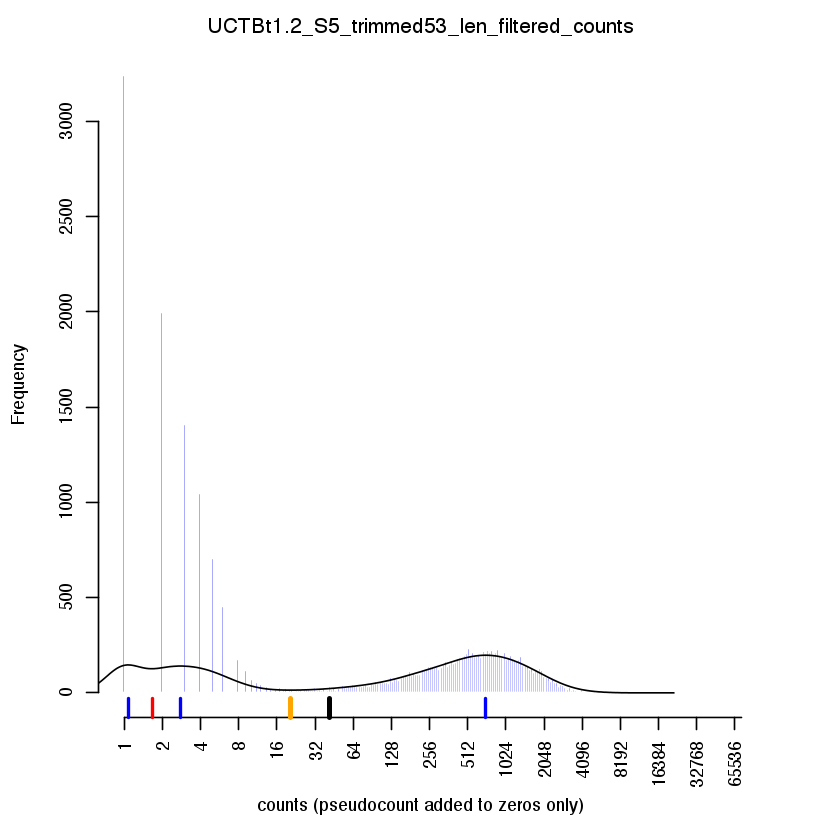

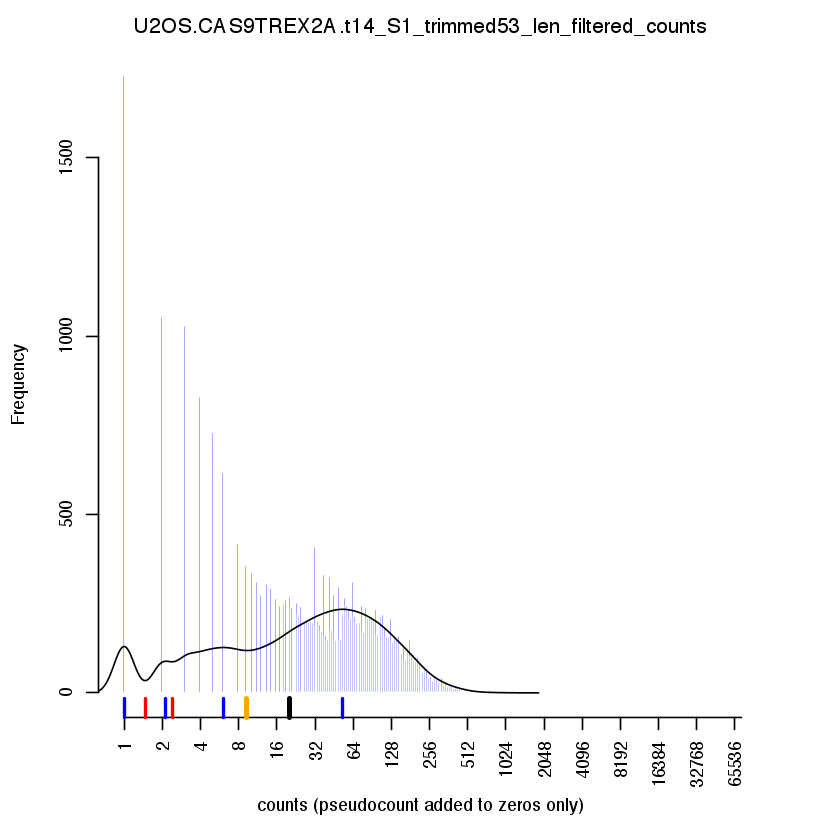

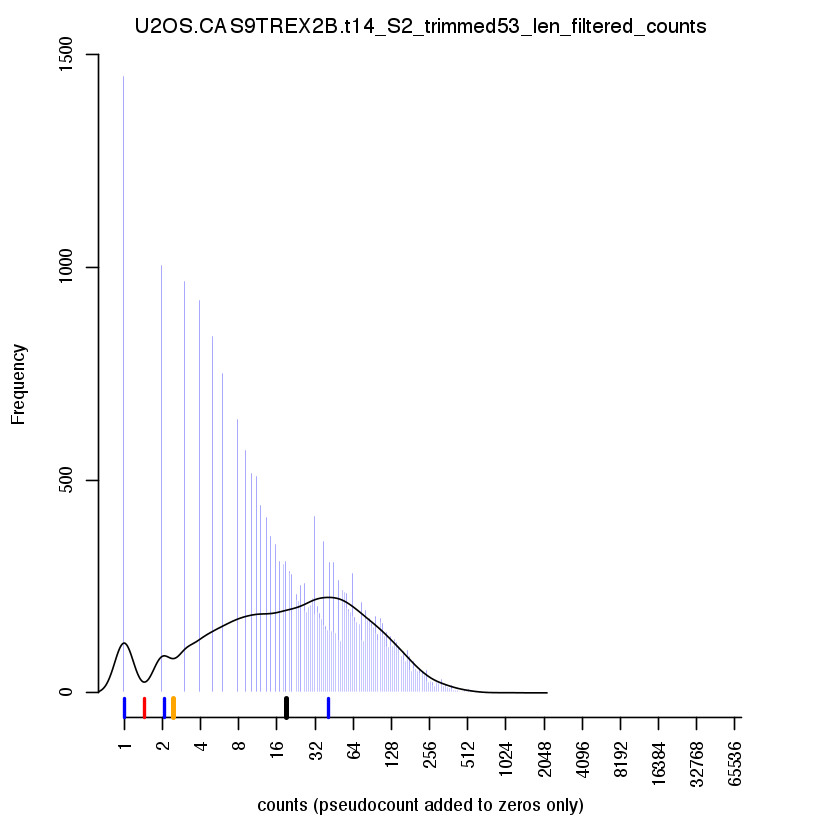

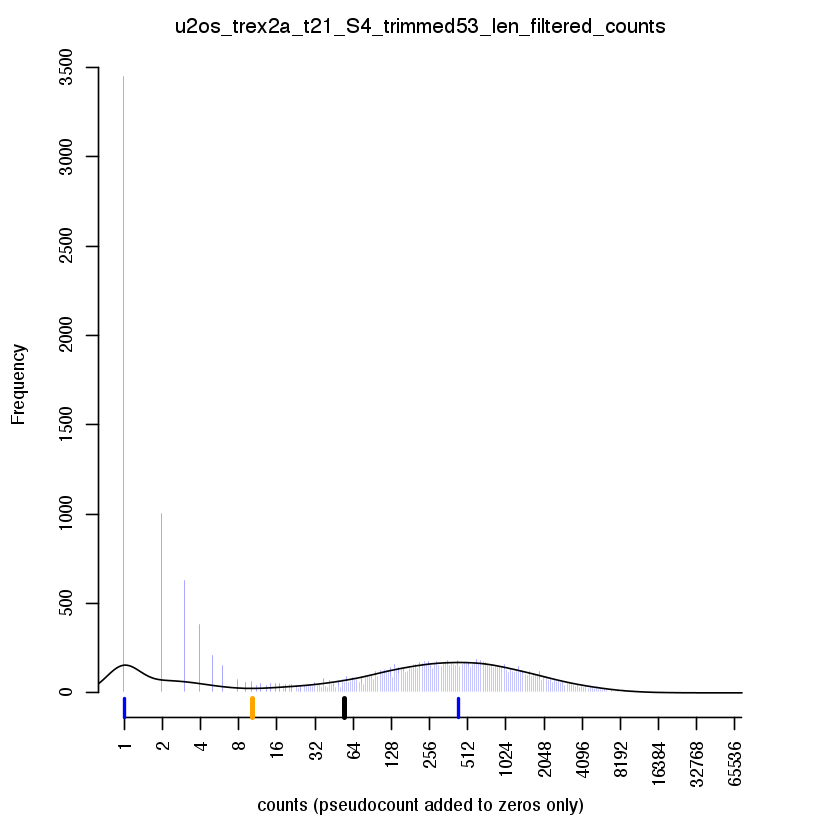

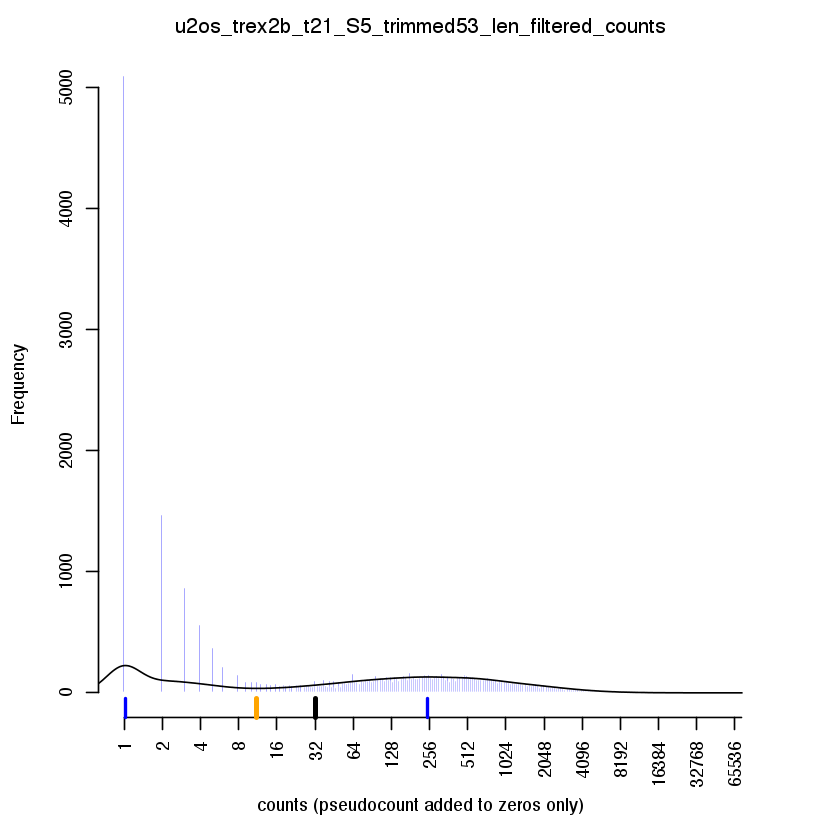

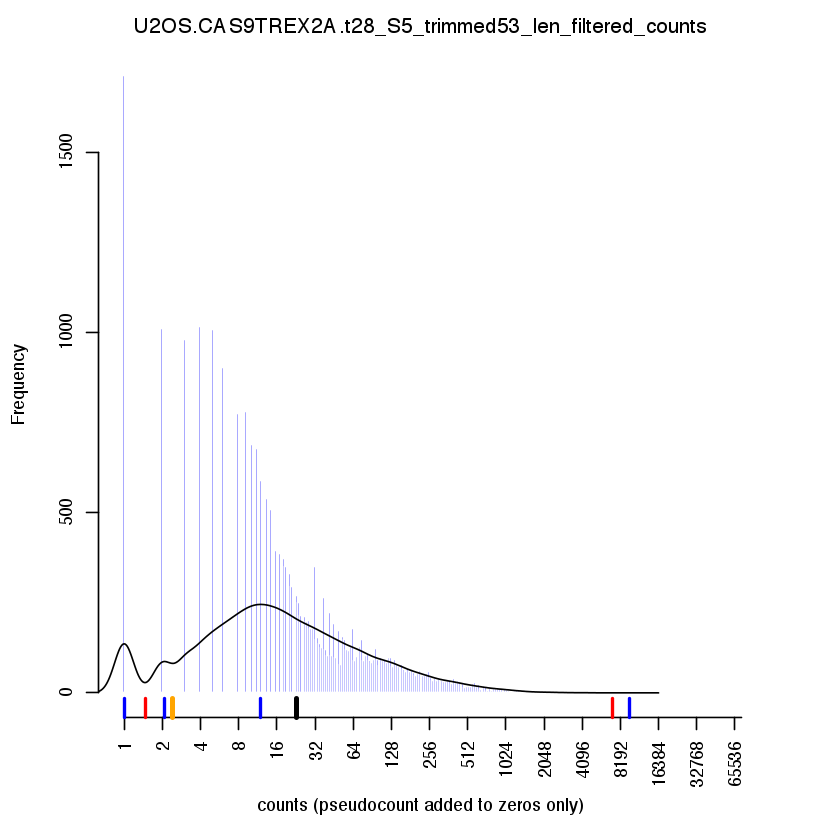

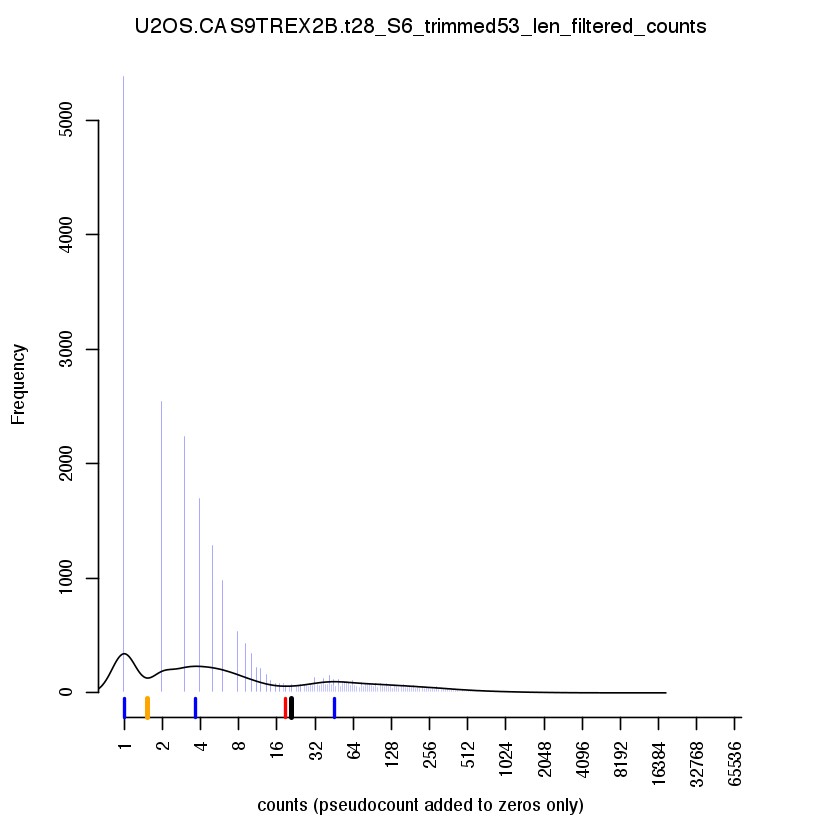

In [484]:
drawCountDists3(goodCounts, goodCountsManualThresholds, findAndPlotDensityExtremaAndDiffs)
drawCountDists3(poorCounts, poorCountsManualThresholds, findAndPlotDensityExtremaAndDiffs)

Well, that was a mixed bag.  On the good side, u2os_trex2a_t21_S4 now has the best minimum chosen, and U2OS.CAS9TREX2A.t28_S5 (the really weird one) at least looks better, while Hela.CV4R4R_d3_1_s7, UCTBt1.2_S5, and U2OS.CAS9TREX2A.t14_S1 remain correct--but this approach does worse than the simpler "rightmost minimum" heuristic for U2OS.CAS9TREX2B.t28_S6, and the remainder of the samples (UCTAt1.2_S4, U2OS.CAS9TREX2B.t14_S2, and u2os_trex2b_t21_S5) are still wrong.  Why?  Well, because saying I pick the minimum adjacent to the "largest jump" wasn't a full description of what I actually do ... actually, I decide which peak I think represents the "real" count distribution, and then I look for the largest jump adjacent to *that* peak, ignoring others (like the far-left small-count peaks).  In the poor data, it is definitely *not* true that the "real" peak has a greater overall maximum than the "noise" peak(s)--which is why my "largest jump" approach didn't work too well.  I *could* throw out any minimum found adjacent to 1, but there could be additional noisy peaks (at 2, etc) that could *still* have larger jumps than the "real" distribution if that real distrubution looks as anemic as, say, U2OS.CAS9TREX2B.t28_S6.  While I don't like arbitrary thresholds, I think this may be the time for one.  However, although it is the minimum I'm trying to select, I think I want to apply the threshold to its adjacent *maximum*--if the maximum to the right of the minimum is at too low a number of counts (say, 2, 3, etc), then we're looking at a noise peak and we don't want to pick the abundance threshold adjacent to it.  (Note that the global count threshold will apply to ALL samples, and I think can be reasonably set ahead of time, so it will not be as onerous as the per-sample abundance threshold whose selection I'm trying to automate here).

In [476]:
gCountThresholdForLocationOfMainPeakMax = 10 #Note: in absolute counts, not log2

In [477]:
gCountsColName = "log2CountsAtExtrema"
gFreqsColName = "freqsAtExtrema"


findAndPlotDensityExtremaAndDiffs2<-function(densityObj){
    countThreshForMax = gCountThresholdForLocationOfMainPeakMax
    
    getMins = TRUE
    indicesOfMins = findDensityExtremaIndices(densityObj, getMins)
    plotDensityExtrema(densityObj, indicesOfMins, getMins)        
    
    getMins = FALSE
    indicesOfMaxes = findDensityExtremaIndices(densityObj, getMins)
    plotDensityExtrema(densityObj, indicesOfMaxes, getMins)   
    
    log2CountsAtChosenMin = getLog2CountsAtMinWithBiggestDiff2(densityObj, 
        indicesOfMins, indicesOfMaxes, countThreshForMax)
    if (!is.null(log2CountsAtChosenMin)) {
        plotExplicitThresholds(c(log2CountsAtChosenMin), areLog2=TRUE, color="orange")        
    } else {
        print("No minimum chosen")
    }
}
     
    
getLog2CountsAtMinWithBiggestDiff2<-function(densityObj, indicesOfMins, indicesOfMaxes, countThreshForMax){
    minsByDescLog2Counts = getlog2CountsAndFreqsAtExtrema2(densityObj, indicesOfMins, TRUE)
    maxesByDescLog2Counts = getlog2CountsAndFreqsAtExtrema2(densityObj, indicesOfMaxes, FALSE)
    currIndexOfMin = 1
    currIndexOfMax = 1
    if (minsByDescLog2Counts[1, gCountsColName] > maxesByDescLog2Counts[1, gCountsColName]){
        print("rightmost extremum is a minimum")
        currIndexOfMin = 2
    }    

    maxDiffInFreqs = 0
    log2CountsAtMinWithBiggestDiff = NULL

    while ((currIndexOfMin <= nrow(minsByDescLog2Counts)) & 
           (currIndexOfMax <= nrow(maxesByDescLog2Counts))) {
        
        if (maxesByDescLog2Counts[currIndexOfMax, gCountsColName] < log2(countThreshForMax)) {
            break
        }        

        currMaxFreq = maxesByDescLog2Counts[currIndexOfMax, gFreqsColName]
        currMinFreq = minsByDescLog2Counts[currIndexOfMin, gFreqsColName]

        currFreqDiff = currMaxFreq - currMinFreq
        if (currFreqDiff > maxDiffInFreqs){
            maxDiffInFreqs = currFreqDiff
            log2CountsAtMinWithBiggestDiff = minsByDescLog2Counts[currIndexOfMin, gCountsColName]
        }
        currIndexOfMin = currIndexOfMin + 1
        currIndexOfMax = currIndexOfMax + 1
    }    
    
    return(log2CountsAtMinWithBiggestDiff)
}

       
getlog2CountsAndFreqsAtExtrema2<-function(densityObj, indicesOfExtrema, getMins=TRUE){
    log2CountsAtExtrema = densityObj$x[indicesOfExtrema]
    densityFunc = approxfun(densityObj)
    freqsAtExtrema = densityFunc(log2CountsAtExtrema)
    result = data.frame(log2CountsAtExtrema, freqsAtExtrema)
    result = result[with(result, order(-log2CountsAtExtrema)), ]   
    colnames(result) = c(gCountsColName, gFreqsColName)
    return(result)    
}        

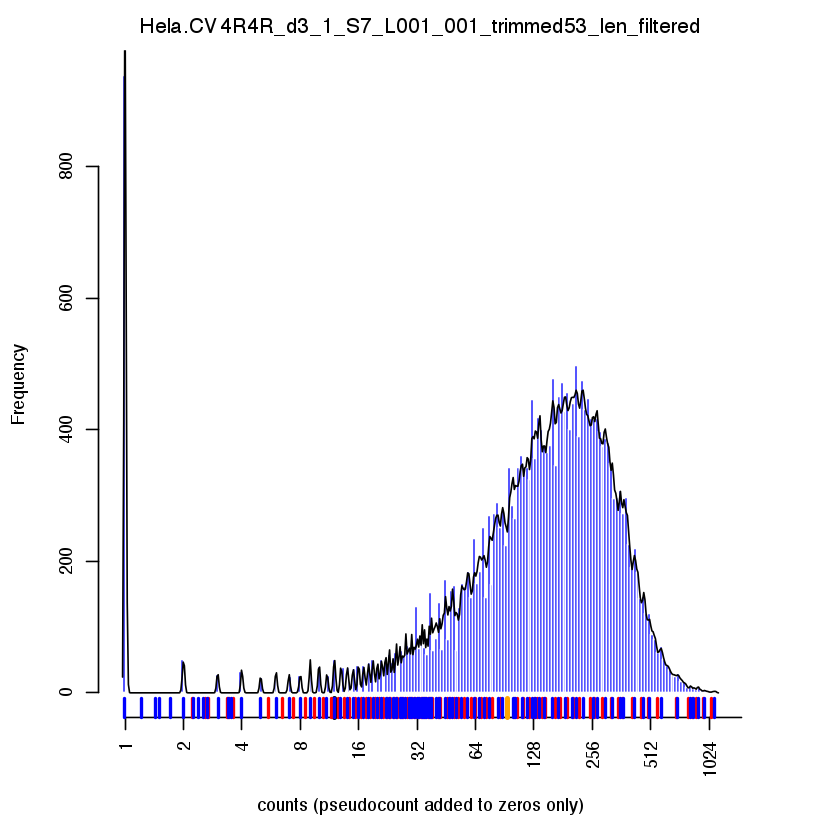

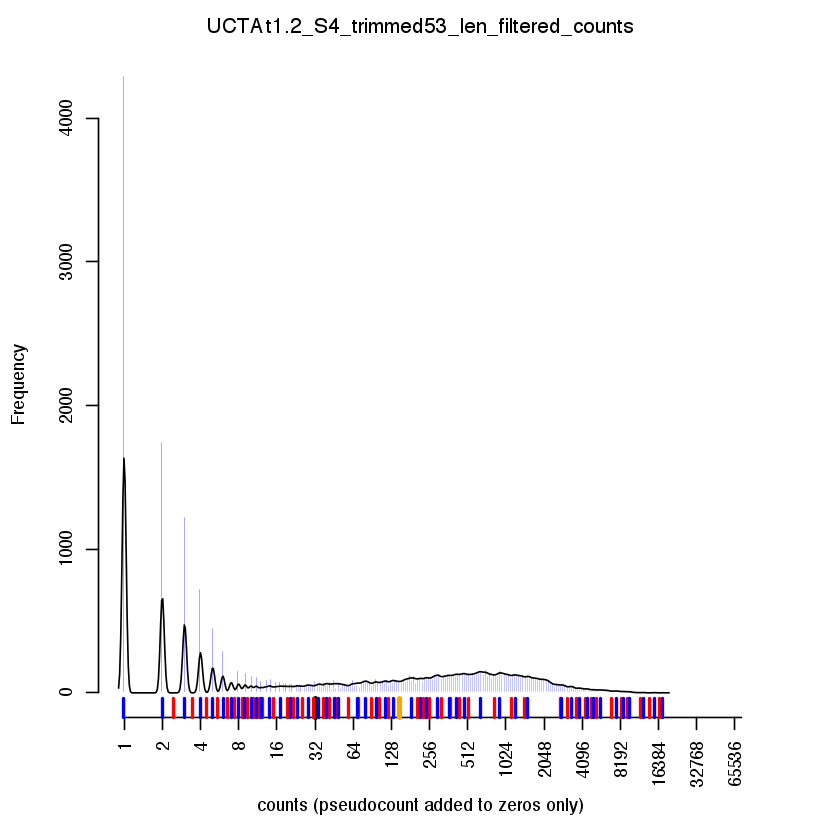

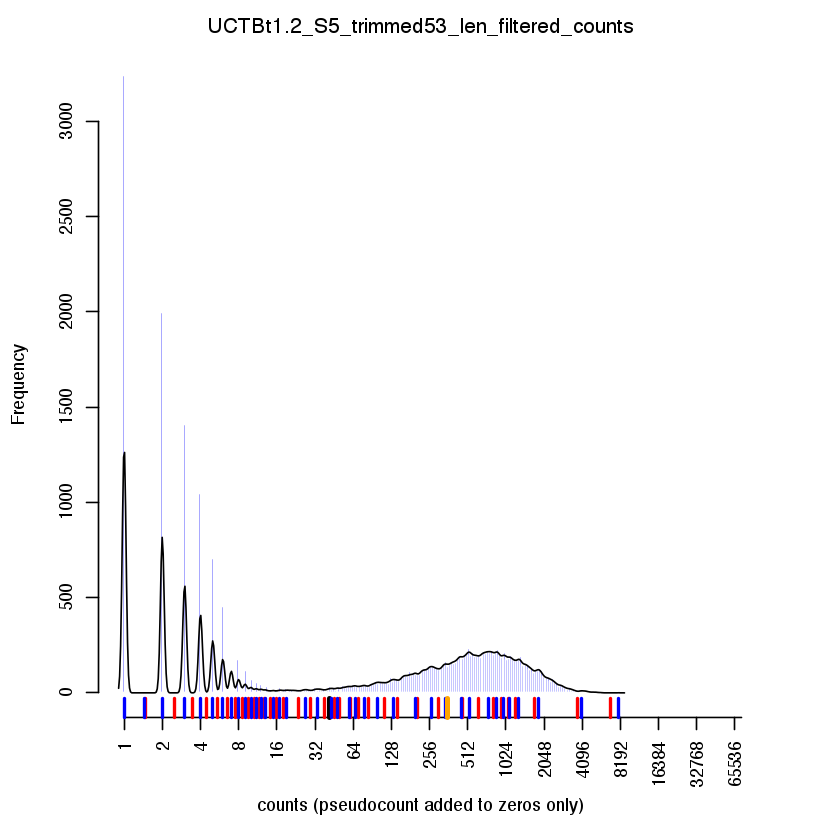

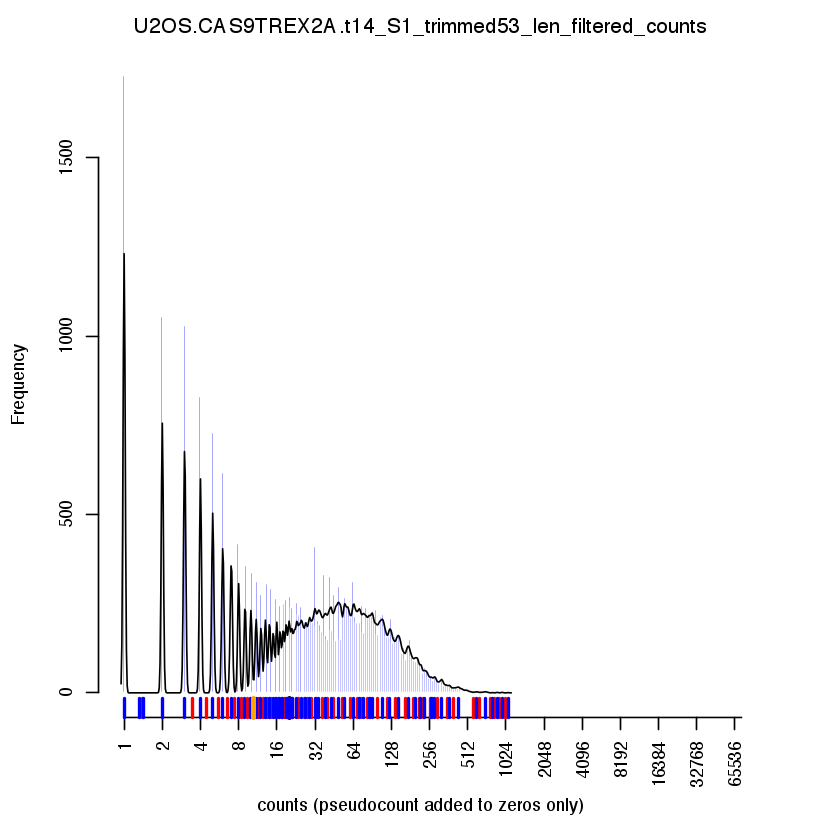

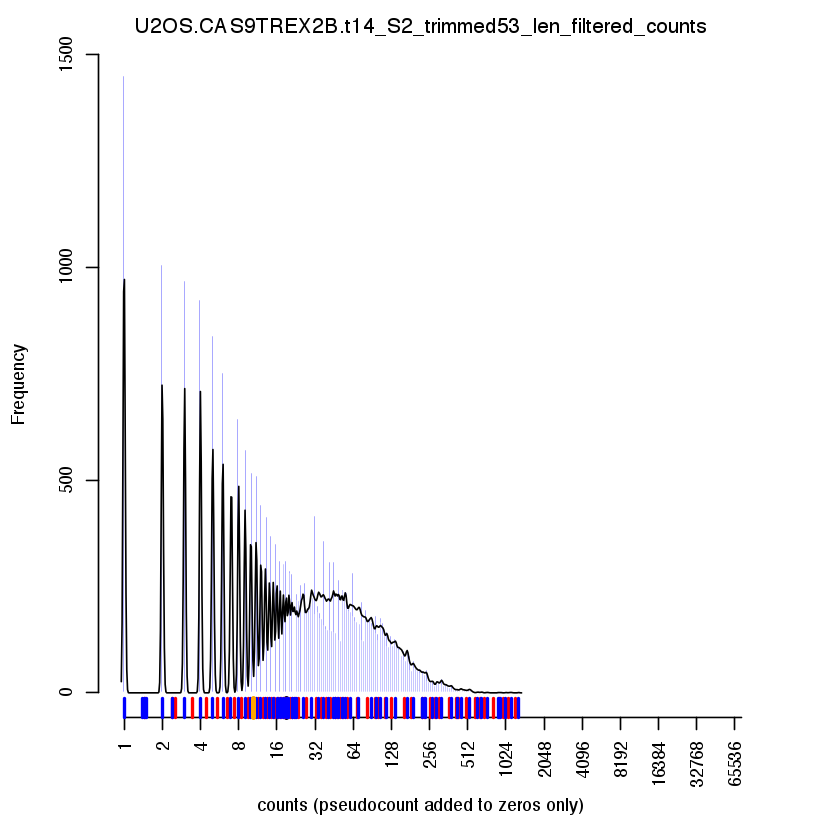

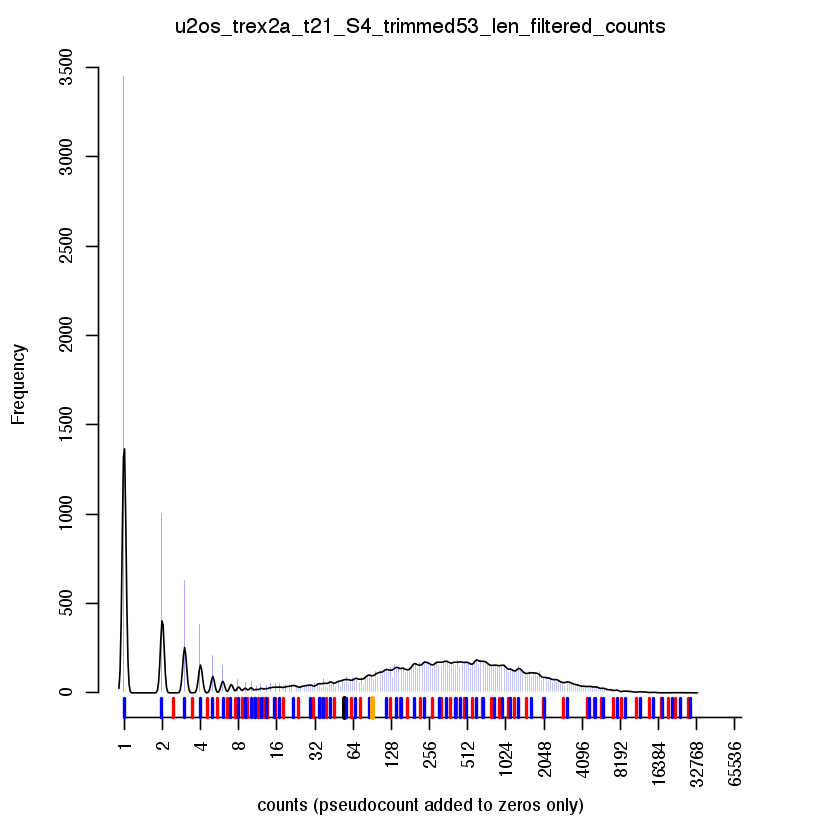

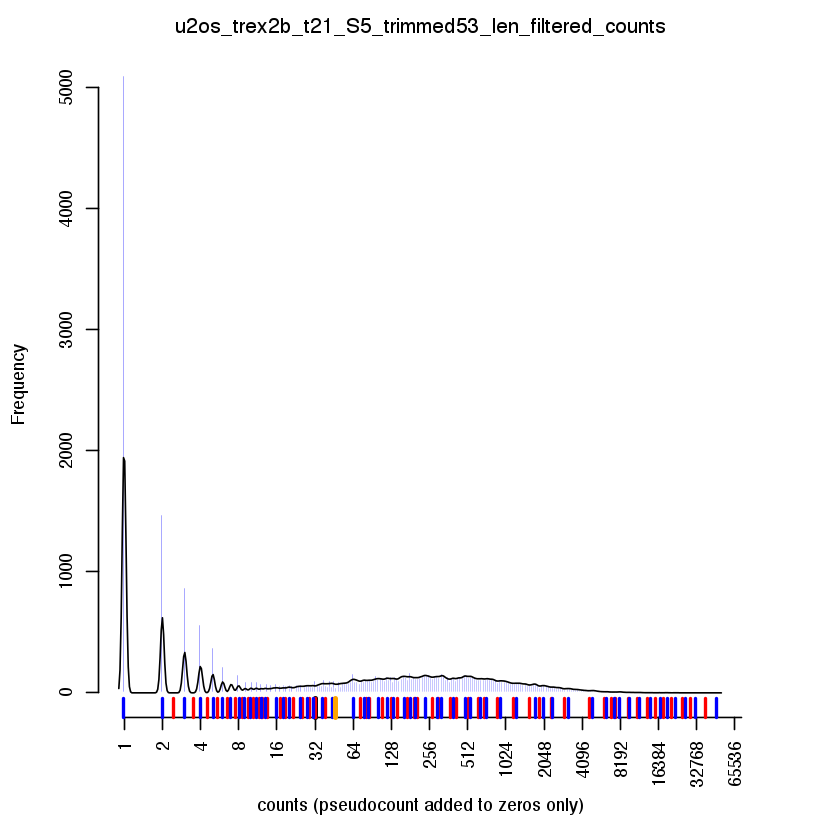

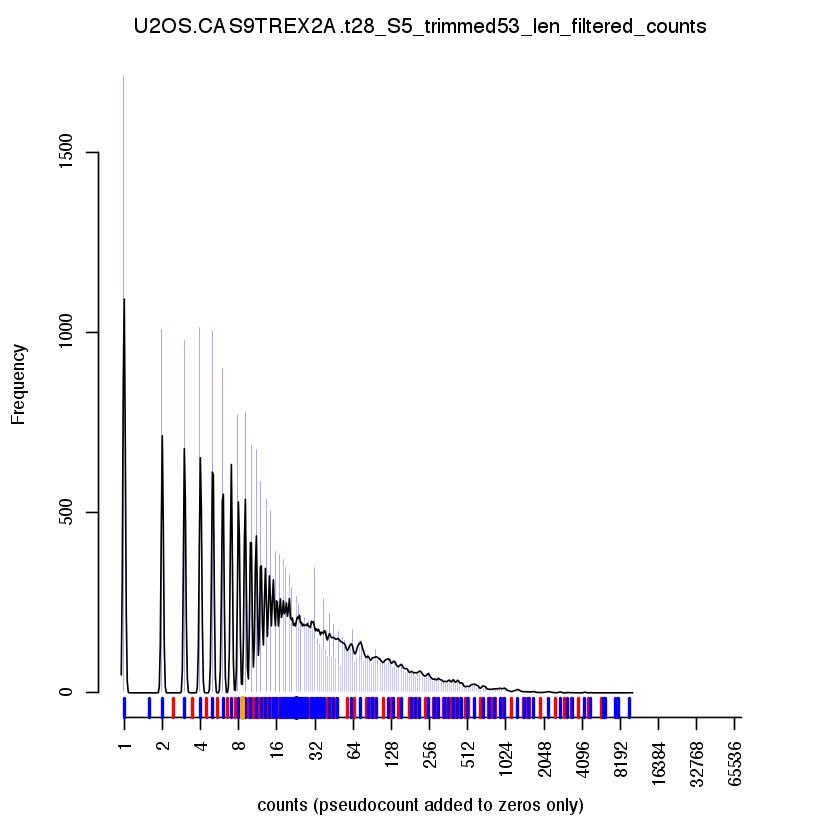

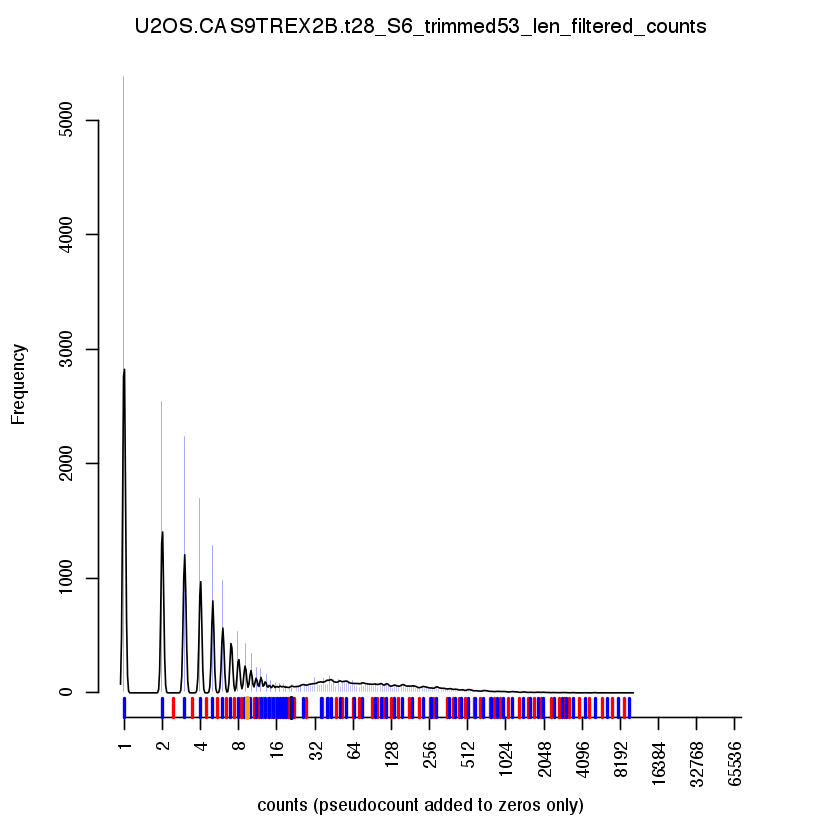

In [478]:
drawCountDists3(goodCounts, goodCountsManualThresholds, findAndPlotDensityExtremaAndDiffs2)
drawCountDists3(poorCounts, poorCountsManualThresholds, findAndPlotDensityExtremaAndDiffs2)

Ok, that was a definite improvement: none of the ones where the threshold pick was good before got worse, and UCTAt1.2_S4, u2os_trex2a_t21_S4, and U2OS.CAS9TREX2B.t28_S6 joined the ranks of good picks.  U2OS.CAS9TREX2B.t14_S2 still isn't where I want it, but I don't actually know if I'd want it to select the local minimum closer to the manually selected threshold--that dataset is so weird.

At least for the moment, I am going to treat the approach above as an acceptable (although clearly not perfect) solution to Issue #1 (There is more than one minimum, and the code will need to be able to pick which one on which to anchor).

#### Issue 2: Thresholds should be a bit to the right of the chosen minimum

I really don't know how the decision about *how much* to the right of the minimum was made ... in the cases where I made it, I tried to mimic the sorts of choices I'd seen Roman make.  I think I was trying to find a spot "safely" inside the "main" peak, as defined by the fact that the peak had risen enough that I could tell it the spot I picked definitely wasn't noise.  How about I start from the minimum selected by the algorithm above, and then move right till I find a point that is some arbitrary minimum percentage of the maximum height of the main peak, and then put the threshold there?  Argh, those arbitrary thresholds do like to creep in ... still, as with the one above, this will be global (rather than per-sample) and a reasonable default should be possible.

Of course, I'll have to *determine* the "maximum height of the main peak", which *isn't* just the maximum that comes before the chosen minimum (for a concrete counterexample above, see U2OS.CAS9TREX2B.t14_S2).  Rather, I think I want the maximum height of the main peak to be *global* interior maximum of all the distribution that lies to the *right* of the chosen anchor.

In [449]:
gPeakHeightFractionAtThreshold = 0.05

In [450]:
findAndPlotDensityExtremaAndDiffs3<-function(densityObj){
    countThreshForMax = gCountThresholdForLocationOfMainPeakMax
    
    getMins = TRUE
    indicesOfMins = findDensityExtremaIndices(densityObj, getMins)
    plotDensityExtrema(densityObj, indicesOfMins, getMins)        
    
    getMins = FALSE
    indicesOfMaxes = findDensityExtremaIndices(densityObj, getMins)
    plotDensityExtrema(densityObj, indicesOfMaxes, getMins)   
    
    log2CountsAtChosenMin = getLog2CountsAtMinWithBiggestDiff2(densityObj, 
        indicesOfMins, indicesOfMaxes, countThreshForMax)
    if (!is.null(log2CountsAtChosenMin)) {
        plotExplicitThresholds(c(log2CountsAtChosenMin), areLog2=TRUE, color="orange")
        putativeThreshold = findThresholdAtMinPeakHeight(densityObj, indicesOfMaxes, log2CountsAtChosenMin)
        plotExplicitThresholds(putativeThreshold, areLog2=TRUE, color="green")
    } else {
        print("No minimum chosen")
    }
}
   

findThresholdAtMinPeakHeight<-function(densityObj, indicesOfMaxes, log2CountsAtChosenMin){
    log2countsAndFreqsAtLocalMaxima = getlog2CountsAndFreqsAtExtrema2(densityObj, indicesOfMaxes, getMins=FALSE)
    freqsAtMaximaGteChosenMin = log2countsAndFreqsAtLocalMaxima[
        log2countsAndFreqsAtLocalMaxima[gCountsColName] > log2CountsAtChosenMin, 
        gFreqsColName]
    maxFreqAtMaximaGteChosenMin = max(freqsAtMaximaGteChosenMin)
    
    allowedMinFreqAtThreshold = maxFreqAtMaximaGteChosenMin * gPeakHeightFractionAtThreshold
    minimalDensityDf = data.frame(densityObj$x, densityObj$y)
    colnames(minimalDensityDf) = c(gCountsColName, gFreqsColName)
    # density data is already ordered smallest count to largest count, 
    # so I can just pick the first one (i.e., the min index) that meets the conditions    
    eligibleDensityDf = minimalDensityDf[which(minimalDensityDf$log2CountsAtExtrema >= log2CountsAtChosenMin 
                                                #& minimalDensityDf$log2CountsAtExtrema >= log2(gCountThresholdForLocationOfMainPeakMax)
                                                & minimalDensityDf$freqsAtExtrema >= allowedMinFreqAtThreshold), ]
    putativeThreshold = eligibleDensityDf[[gCountsColName]][1]
    return(putativeThreshold)
}

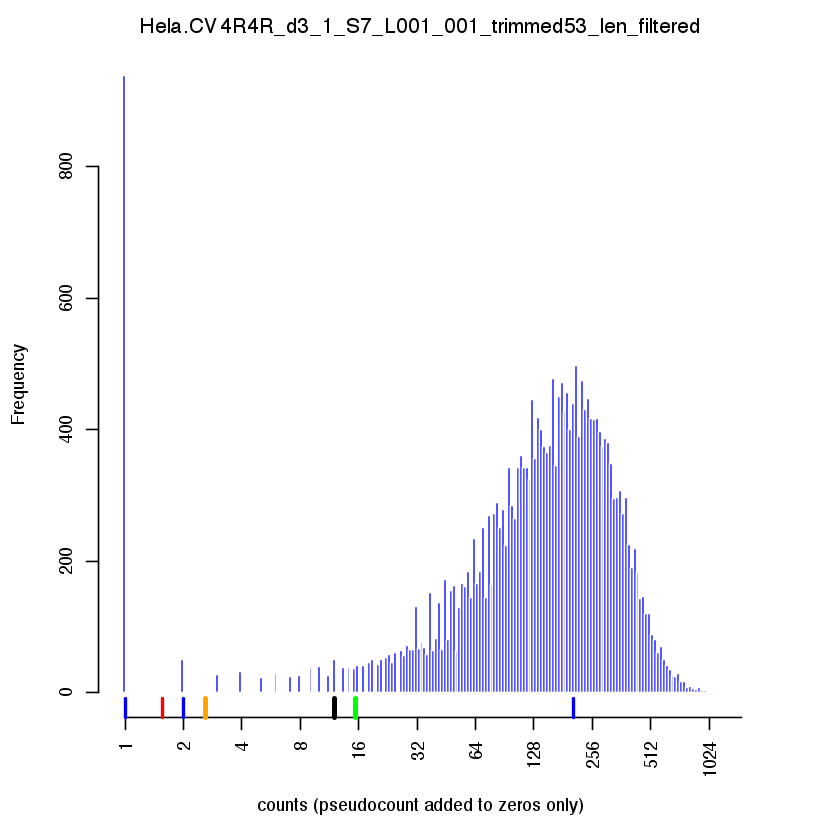

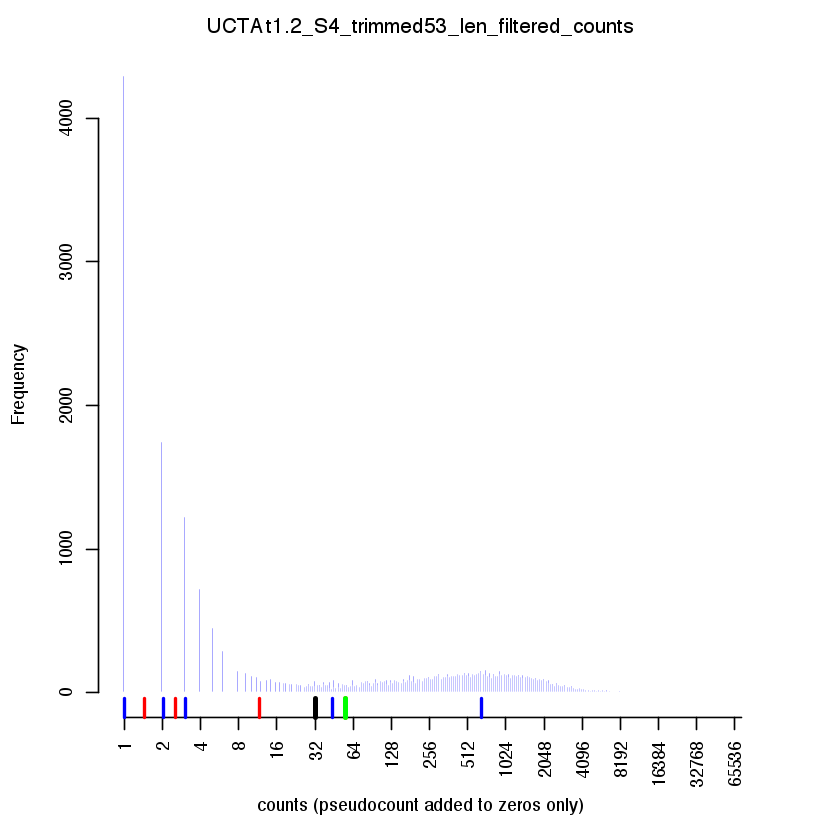

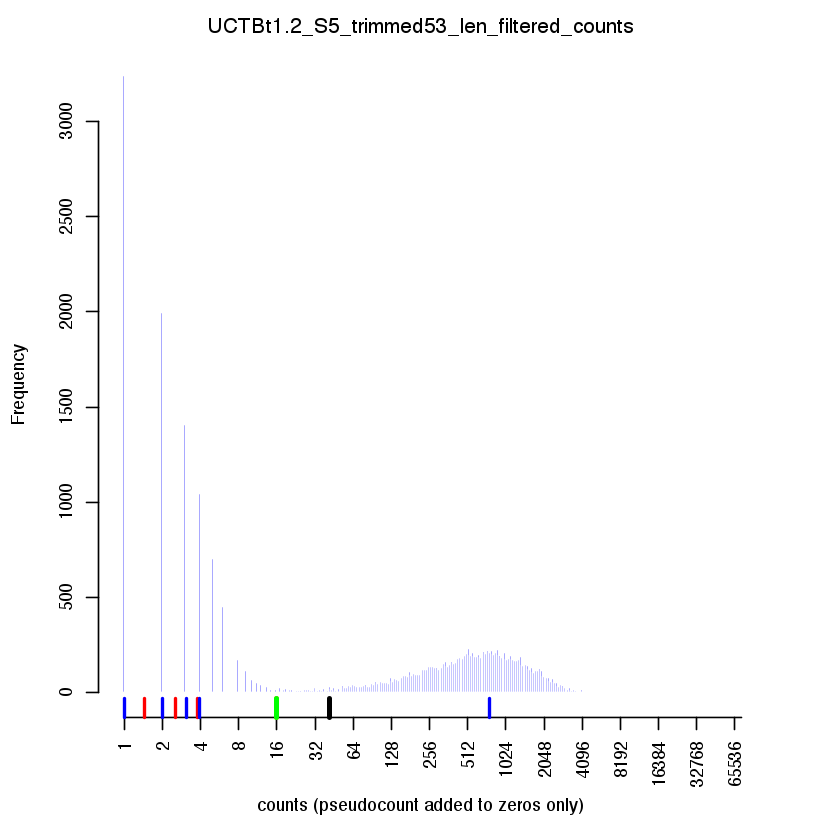

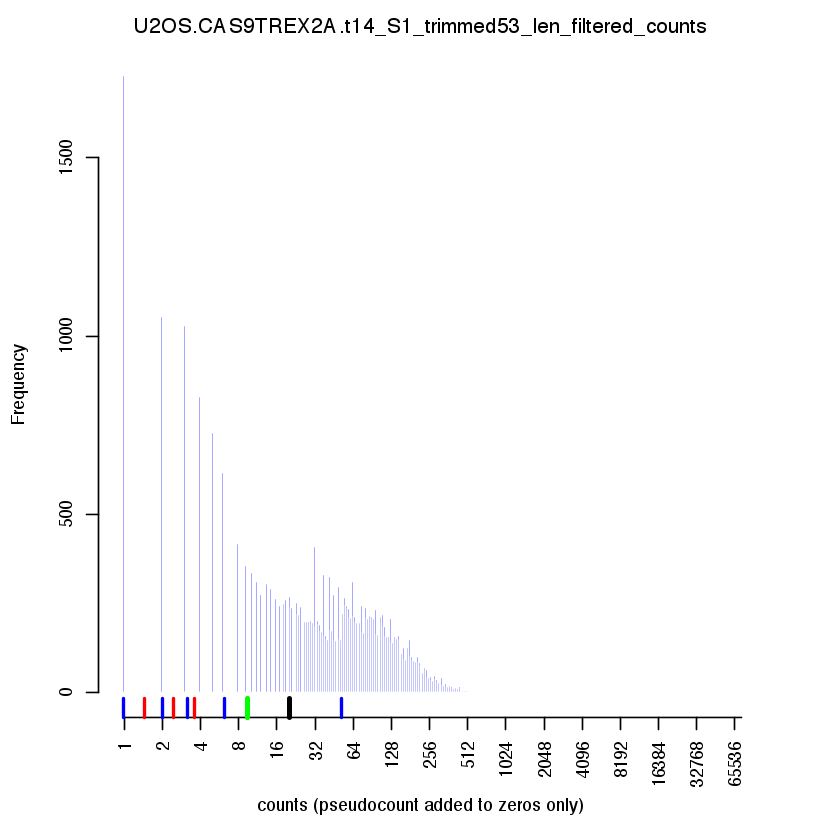

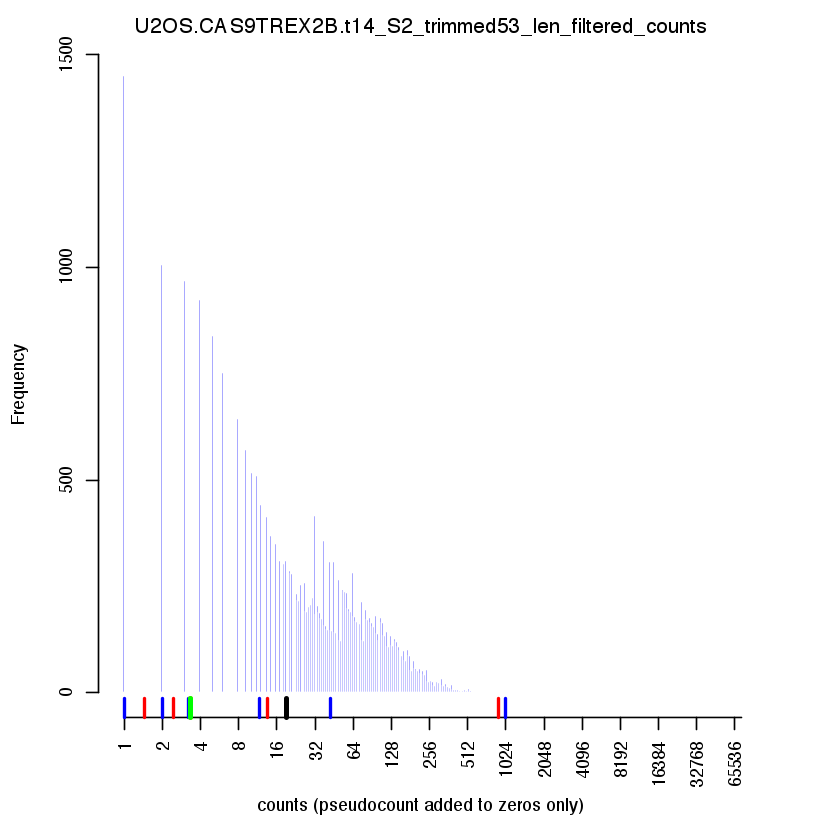

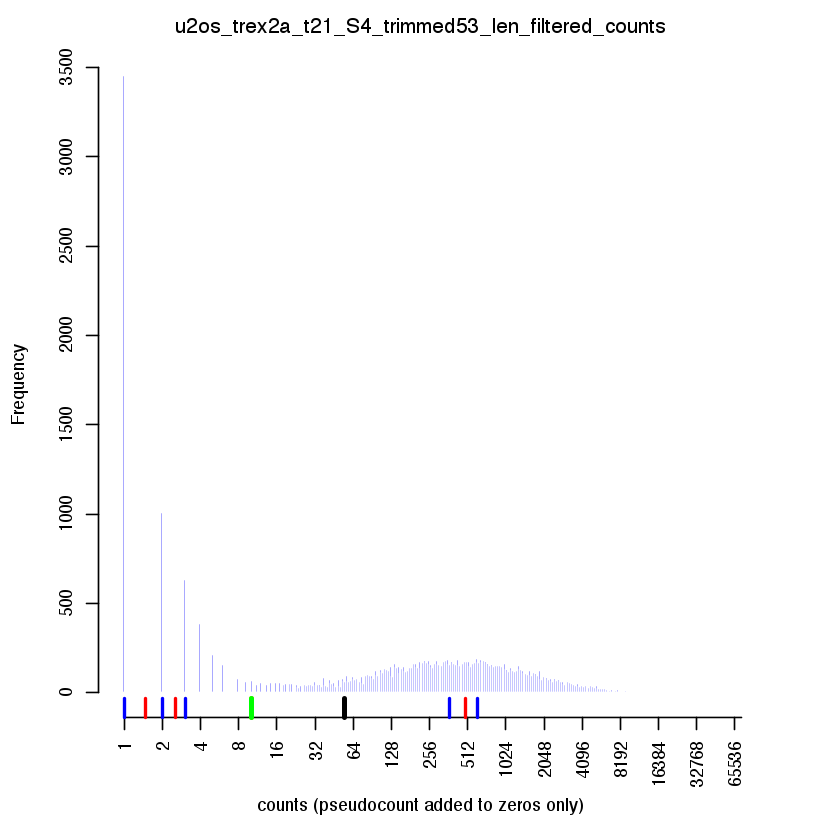

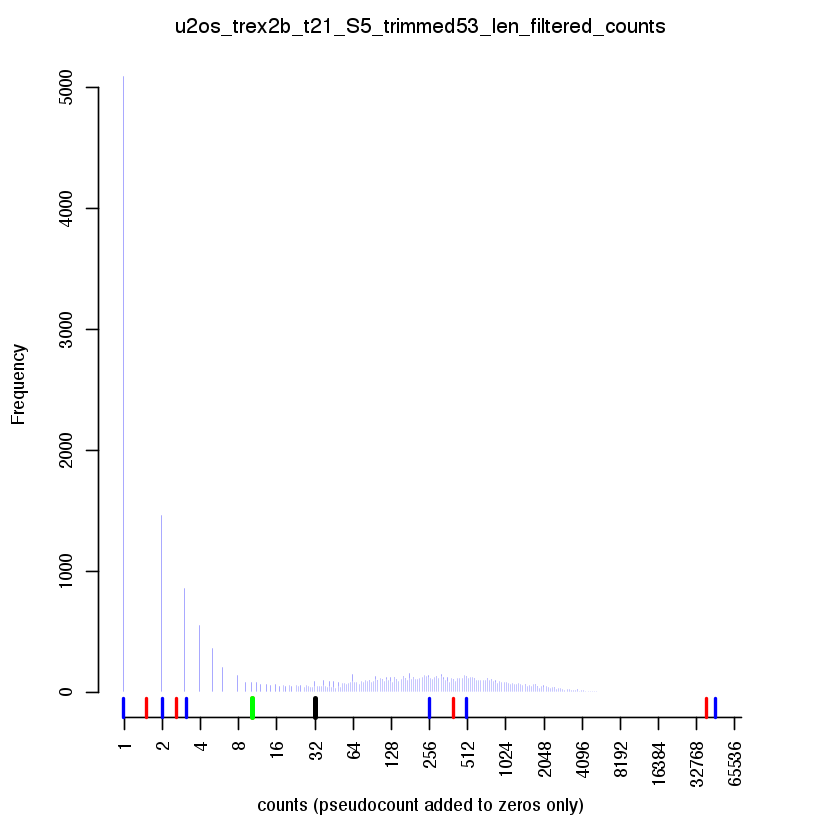

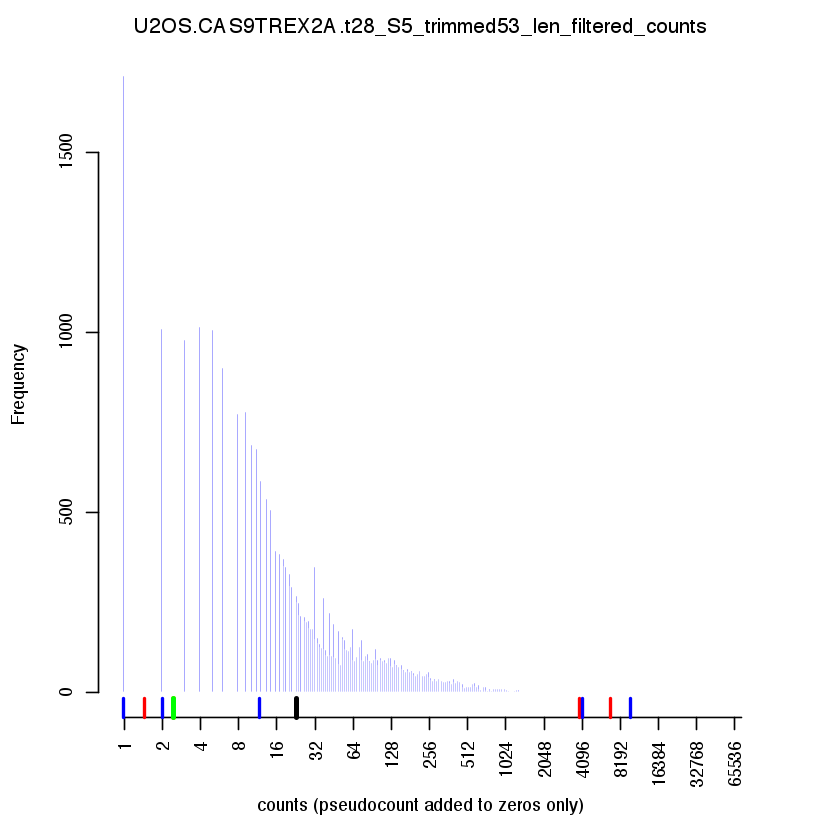

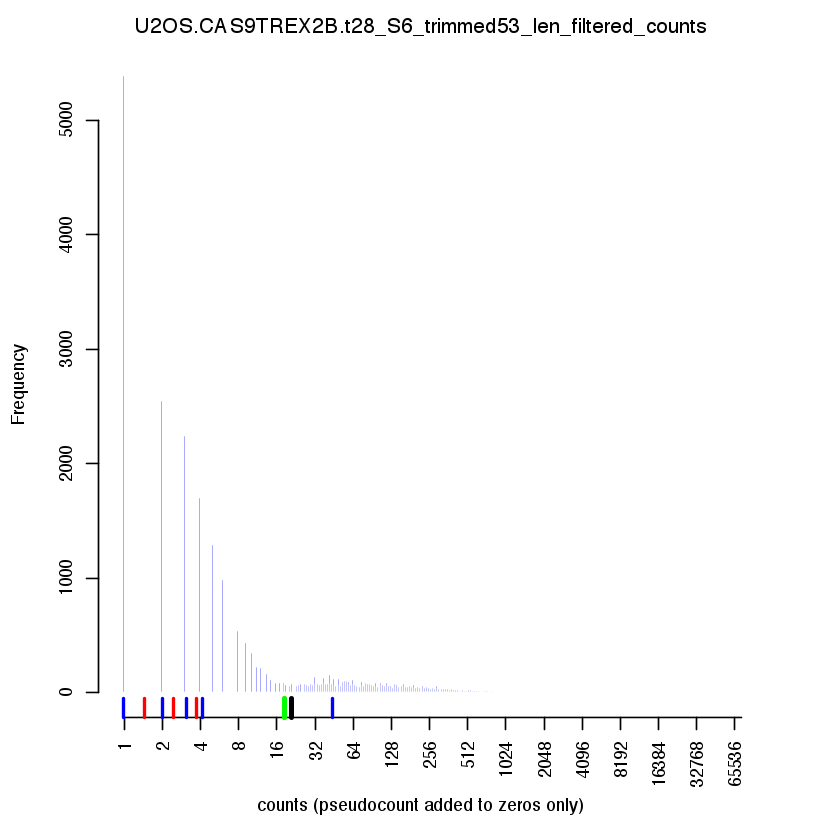

In [456]:
drawCountDists3(goodCounts, goodCountsManualThresholds, findAndPlotDensityExtremaAndDiffs3)
drawCountDists3(poorCounts, poorCountsManualThresholds, findAndPlotDensityExtremaAndDiffs3)

In [309]:
draw_count_dists<-function(y){
    y[y==0]<-1 #pseudocounts
    rge<-range(log2(y))
    x_positions = seq(from = 0, to = ceiling(rge[2])+1, by = 1)
    x_labels = 2^(x_positions)

    for (i in 1:(length(colnames(y)))) {
        z<-log2(y[,i])
        h<-hist(z,
            breaks=seq(0-0.05,rge[2]+0.05,by=0.05),
            main=colnames(y)[i],
            col="blue",
            border=FALSE, 
            xaxt = 'n', 
            xlab="")

        d<-density(z) #,bw=0.2)
        scaler = sum(h$counts)*0.05
        #scaler = max(h$counts)
        lines(d$x,d$y*scaler,col="black")
        axis(side = 1, at = x_positions, labels=x_labels, las=2)

        # add a title for the right axis 
        mtext("counts (pseudocount added to zeros only)", side=1, line=3)
        
        min_indexes = which(diff(sign(diff(d$y)))==+2)+1
        minimums = d$x[min_indexes]
        max_indexes = which(diff(sign(diff(d$y)))==-2)+1
        maximums = d$x[max_indexes]
        rug(minimums,col="red",lwd=2)    
        rug(maximums,col="blue", lwd=2)

        min_and_max_indices = append(min_indexes, max_indexes)

        dens.func = approxfun(d)
        q = d$x[min_and_max_indices]
        #print(q)
        petty = dens.func(q)
        #print(petty*scaler)
        
        #plot(q, petty*scaler)
        
        minimums_by_desc_counts = get_positions_and_vals_for_min_or_max(d, scaler, TRUE)
        maximums_by_desc_counts = get_positions_and_vals_for_min_or_max(d, scaler, FALSE)
        min_index = 1
        max_index = 1
        if (minimums_by_desc_counts[1, "counts_at_extreme"] > maximums_by_desc_counts[1, "counts_at_extreme"]){
            print("rightmost extremum is a minimum")
            min_index = 2
        }
        
        max_diff_in_freq = 0
        counts_at_min_participating_in_max_diff = NULL
        
        while ((min_index <= nrow(minimums_by_desc_counts)) & (max_index <= nrow(maximums_by_desc_counts))) {
            if (maximums_by_desc_counts[max_index, "counts_at_extreme"] < log2(10)) {
                break
            }
            
            curr_max_freq = maximums_by_desc_counts[max_index, "frequency_at_extreme"]
            curr_min_freq = minimums_by_desc_counts[min_index, "frequency_at_extreme"]
 
            curr_freq_diff = curr_max_freq - curr_min_freq
            if (curr_freq_diff > max_diff_in_freq){
                max_diff_in_freq = curr_freq_diff
                counts_at_min_participating_in_max_diff = minimums_by_desc_counts[min_index, "counts_at_extreme"]
            }
            min_index = min_index + 1
            max_index = max_index + 1
        }
        if (!is.null(counts_at_min_participating_in_max_diff)) {
            #rug(counts_at_min_participating_in_max_diff, col="green", lwd=3)
            freq_at_biggest_local_max_right_of_min_participating_in_max_dif = max(maximums_by_desc_counts[
                maximums_by_desc_counts$counts_at_extreme > 
                counts_at_min_participating_in_max_diff, "frequency_at_extreme"])
            #print(freq_at_biggest_local_max_right_of_min_participating_in_max_dif)
            threshold_y = freq_at_biggest_local_max_right_of_min_participating_in_max_dif * 0.25
            temp_df2 = data.frame(d$x, d$y)

            temp_df3 = temp_df2[temp_df2$d.x >= counts_at_min_participating_in_max_diff, ]
            #print(temp_df3)
            rug_val = NULL
            for (i in 1:nrow(temp_df3)) {
                curr_density = temp_df3[i, "d.y"]
                curr_freq = curr_density * scaler
                if (curr_freq > threshold_y){
                    rug_val = temp_df3[i, "d.x"]
                    print(2^rug_val)
                    print(curr_freq)
                    print(threshold_y)
                    break
                }
            }
           #rug(ab0[i],col="black",lwd=2)
           rug(rug_val,col="green", lwd=3)
        }
    }
}

get_positions_and_vals_for_min_or_max<-function(d, scale_var, getMins=TRUE){
    relevant_diff = if(getMins==TRUE) 2 else -2
    relevant_indices = which(diff(sign(diff(d$y)))==relevant_diff)+1
    counts_at_extreme = d$x[relevant_indices]
    density_func = approxfun(d)
    frequency_at_extreme = density_func(counts_at_extreme)*scale_var
    result = data.frame(counts_at_extreme, frequency_at_extreme)
    result = result[with(result, order(-counts_at_extreme)), ]   
    return(result)
}

,Hela.CV4R4R_d3_1_S7_L001_001_trimmed53_len_filtered
1,10700
2,31300
3,34500
4,13400
5,9300
6,36400
7,11600
8,8900
9,9800
10,22700


[1] 4260.087189
[1] 111.6740918
[1] 110.4332982


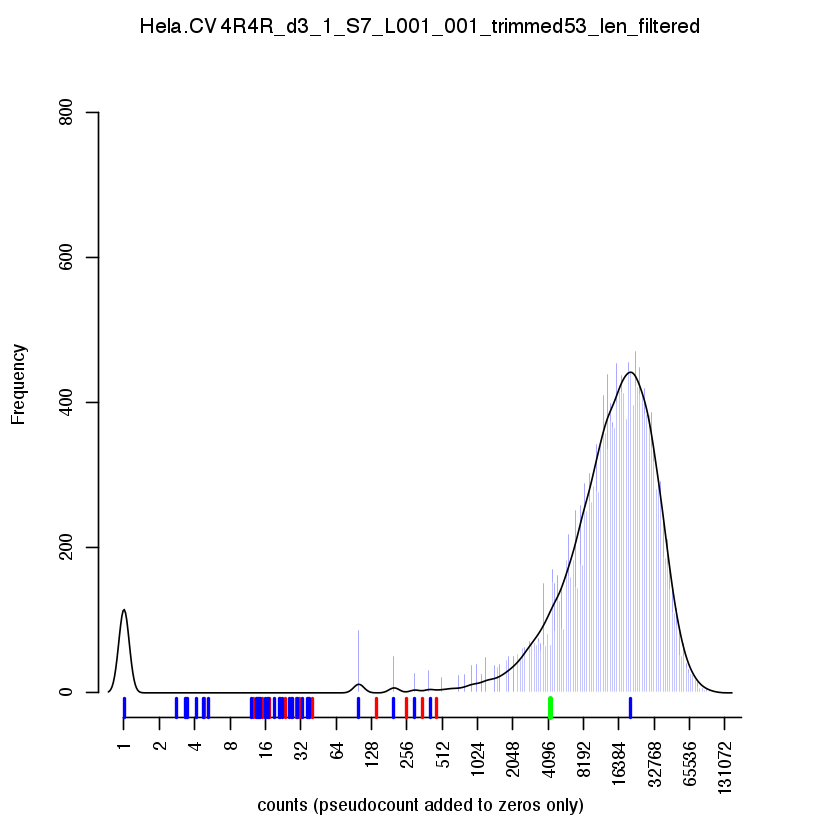

In [312]:
inflated_counts = clear_counts*100
head(inflated_counts, 10)
draw_count_dists(inflated_counts)

,Hela.CV4R4R_d3_1_S7_L001_001_trimmed53_len_filtered
1,207
2,413
3,445
4,234
5,193
6,464
7,216
8,189
9,198
10,327


[1] 112.8522898
[1] 177.371478
[1] 168.9140045


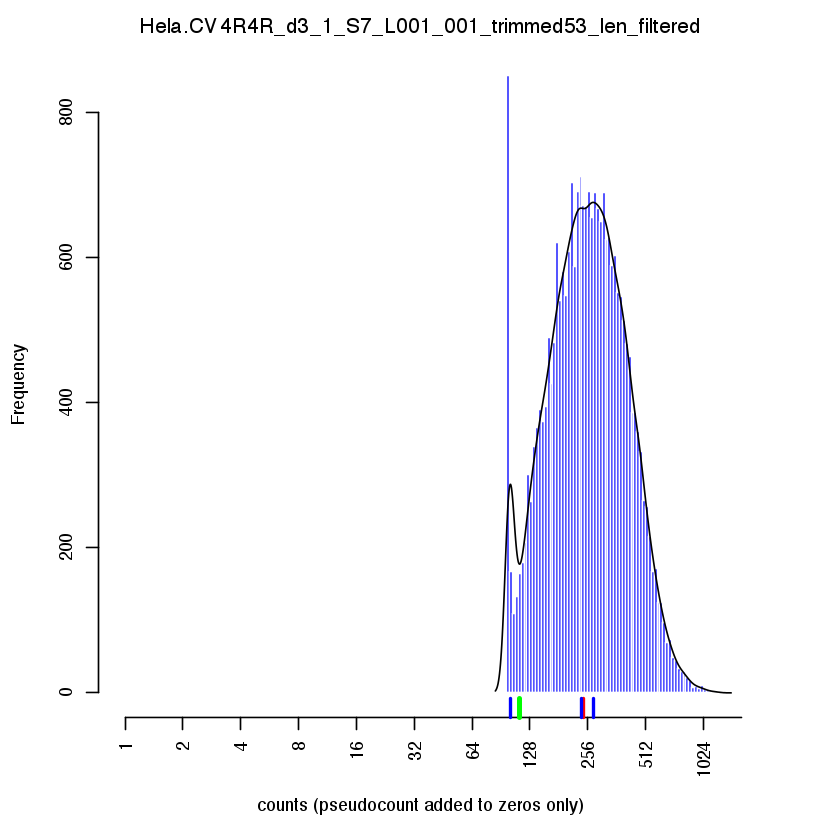

In [313]:
added_counts = clear_counts+100
head(added_counts, 10)
draw_count_dists(added_counts)

,UCTAt1.2_S4_trimmed53_len_filtered_counts,UCTBt1.2_S5_trimmed53_len_filtered_counts,U2OS.CAS9TREX2A.t14_S1_trimmed53_len_filtered_counts,U2OS.CAS9TREX2B.t14_S2_trimmed53_len_filtered_counts,u2os_trex2a_t21_S4_trimmed53_len_filtered_counts,u2os_trex2b_t21_S5_trimmed53_len_filtered_counts,U2OS.CAS9TREX2A.t28_S5_trimmed53_len_filtered_counts,U2OS.CAS9TREX2B.t28_S6_trimmed53_len_filtered_counts
1,1239,1,41,49,268,1149,12,259
2,8,7,35,15,133,28,25,5
3,4,1,78,23,1732,319,96,39
4,591,1369,11,197,190,5106,14,657
5,1413,1,19,16,34,19,2,4
6,2544,11,203,103,2521,656,111,12
7,1,1,4,8,7,1,5,4
8,122,512,41,30,486,99,22,1
9,1,2,4,5,19,3,5,3
10,6,1,13,19,51,18,18,6


[1] 12.83263137
[1] 43.70784584
[1] 33.17236414


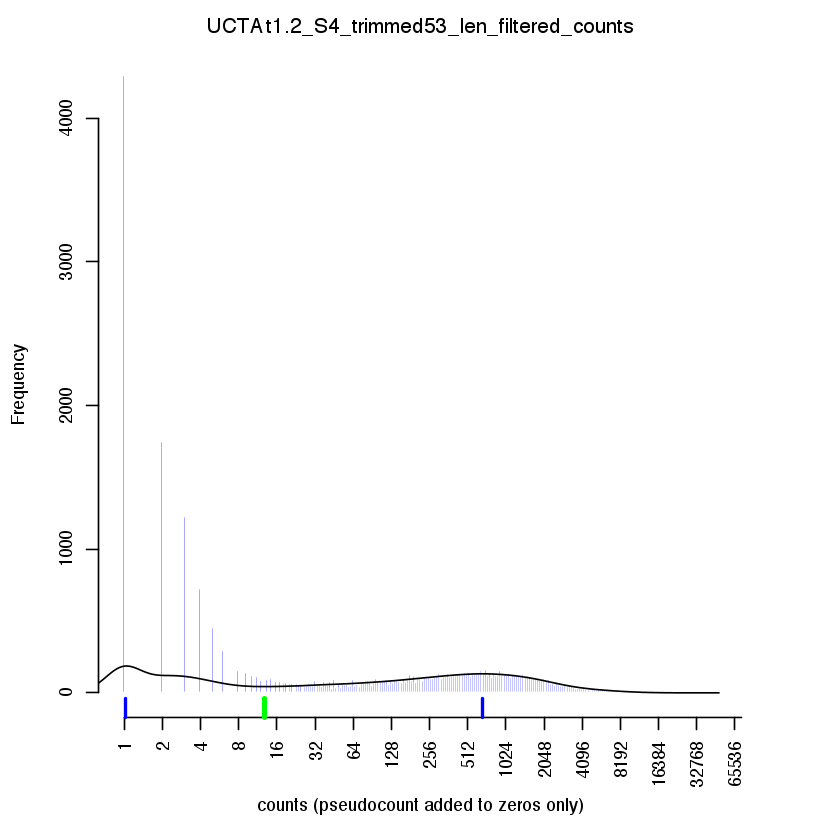

[1] 94.23673866
[1] 50.24241891
[1] 49.40778669


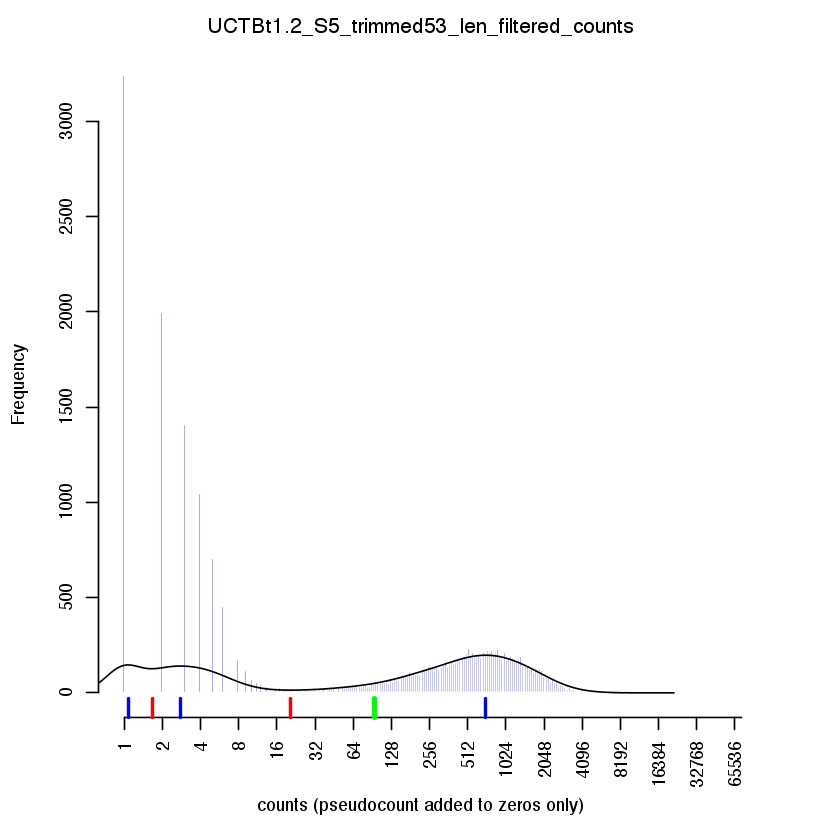

[1] 9.299011126
[1] 118.7928752
[1] 58.57896372


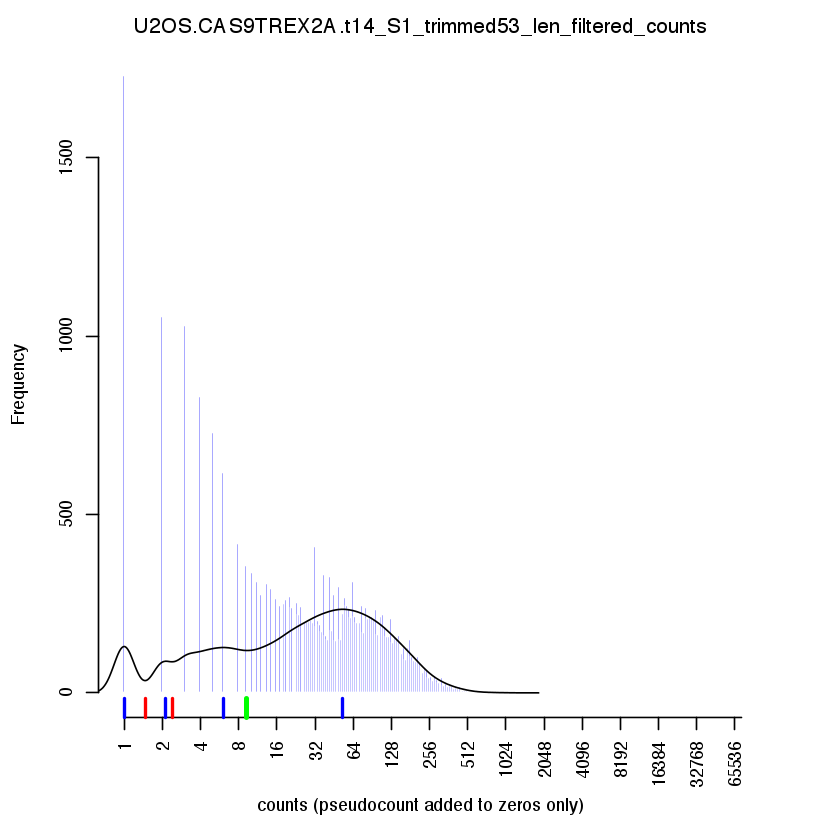

[1] 2.45168709
[1] 80.55056062
[1] 56.08552492


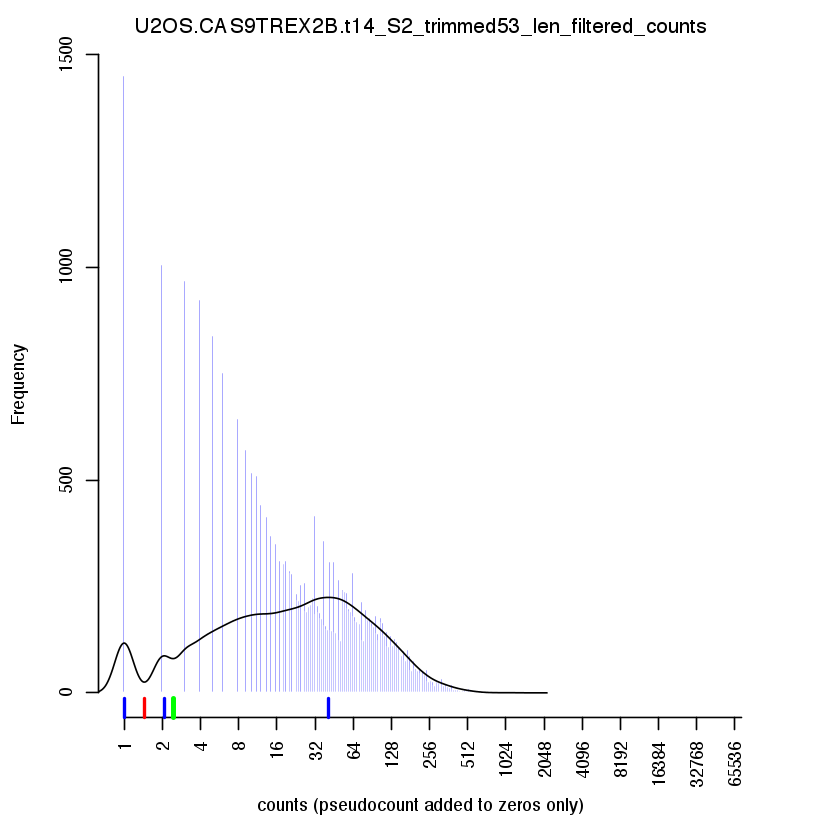

[1] 27.91828774
[1] 42.94847088
[1] 42.45828528


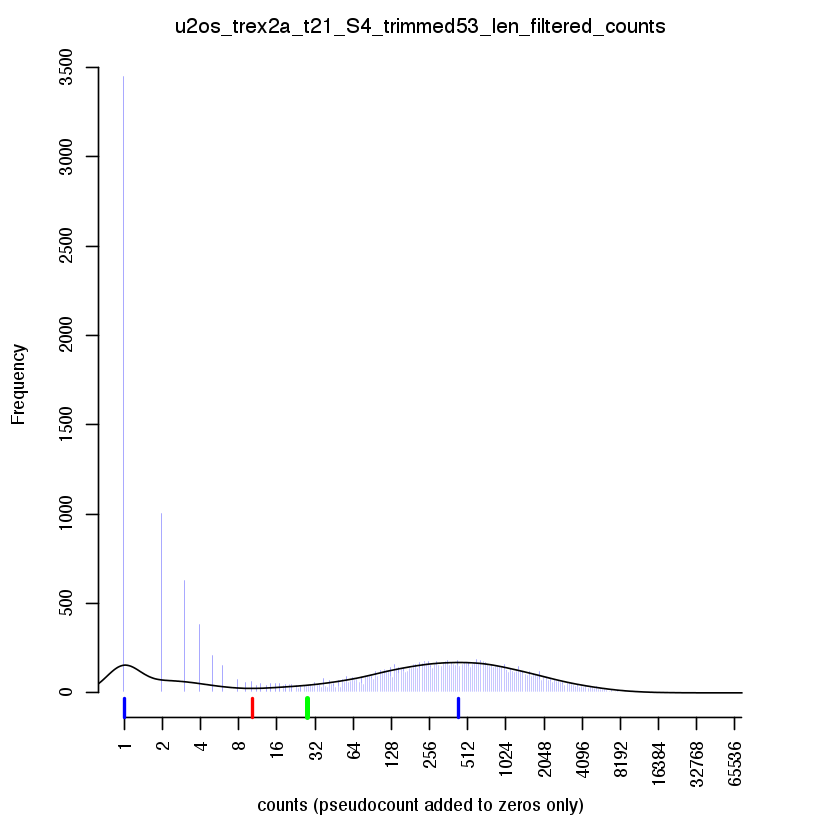

[1] 11.11916523
[1] 37.00704144
[1] 32.81929167


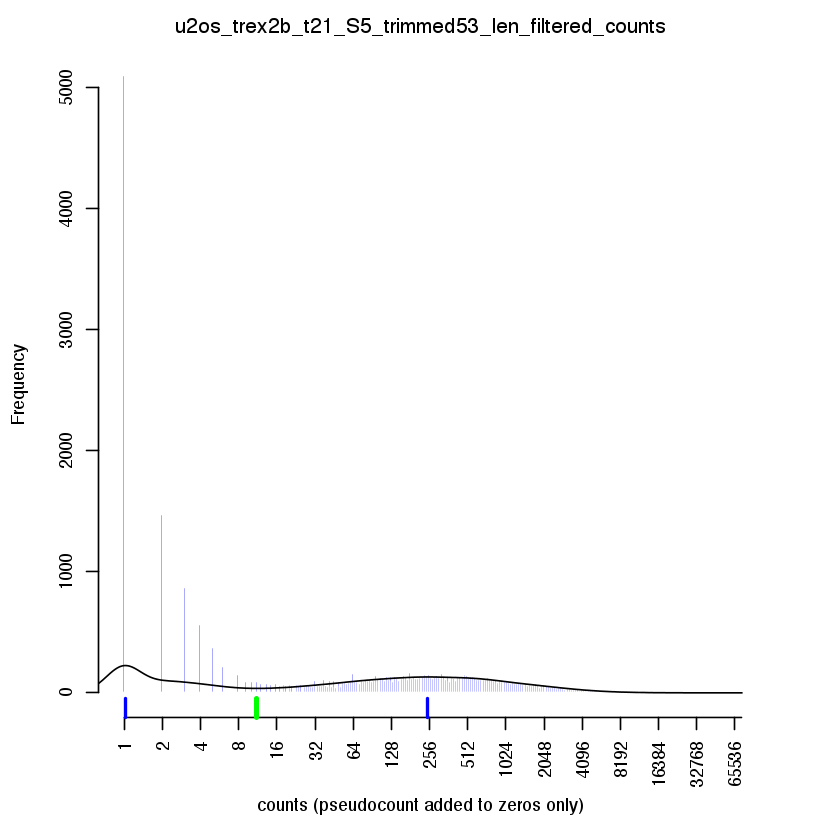

[1] 2.411306848
[1] 81.81241687
[1] 61.35050211


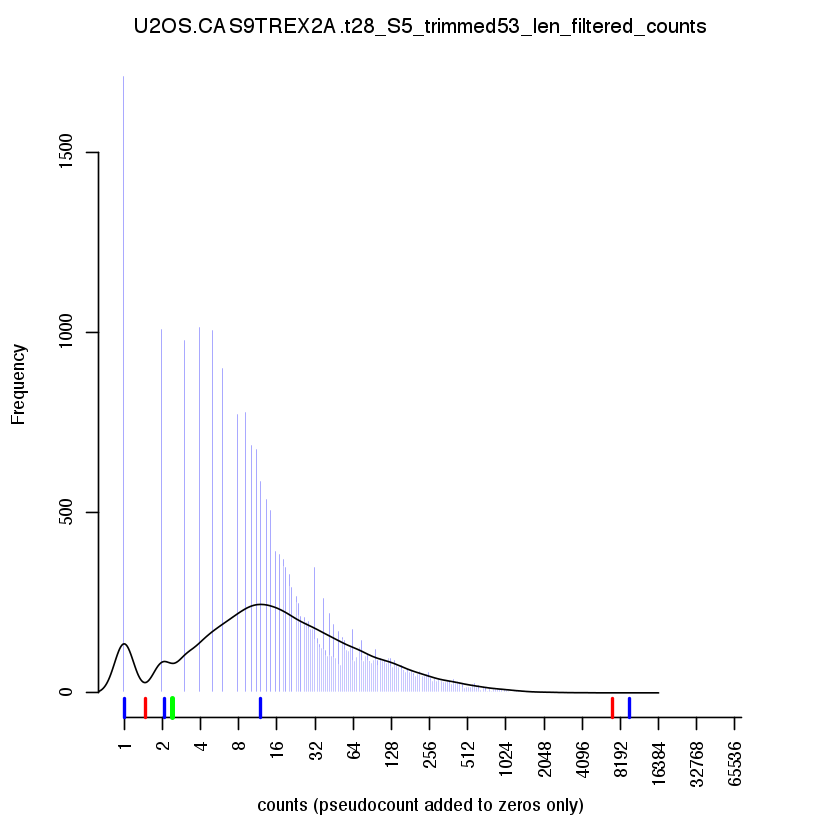

[1] 18.86712471
[1] 58.17277416
[1] 24.40317408


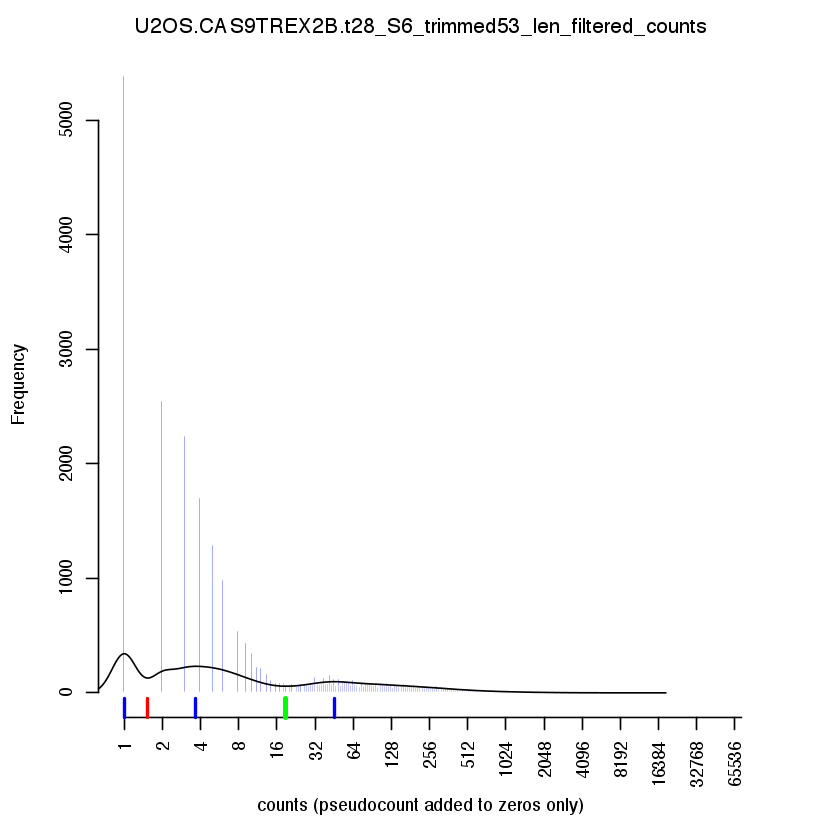

In [582]:
problem_counts = read.table("~/Desktop/ab_y.csv", sep=",", header=TRUE)
head(problem_counts, 10)
draw_count_dists(problem_counts)